# Thesis: Alphafold3 Prediction Analysis
---

In [ ]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats
from datetime import datetime
import matplotlib.colors as mcolors
import os

# Read in data
df_af3= pd.read_csv('../data/af3_results/af3_results.csv')
df_af3 = df_af3.sort_values(['RELEASE_DATE', 'PDB_ID'], ascending=[True, True])

df_boltz1 = pd.read_csv('../data/boltz1_results/boltz1_results.csv')
df_boltz1 = df_boltz1.sort_values(['RELEASE_DATE', 'PDB_ID'], ascending=[True, True])

df_hal = pd.read_csv('../data/hal_04732948/hal_results.csv')
df_hal = df_hal.sort_values(['RELEASE_DATE', 'PDB_ID'], ascending=[True, True])

len(df_af3.index), len(df_boltz1.index),len(df_hal.index)

# Constants
SAVE_PATH = '../data/plots'
AF3_CUTOFF = pd.to_datetime('2021-09-30')

## Config Matplotlib

---

In [7]:
# CCD
color_1 = '#FA6347' # red
color_3 = '#A157DB' # purple
color_5 = '#23C9FF' # light blue

# SMILES
color_2 = '#1E8FFF' # blue
color_4 = '#FC8D62' # orange
color_6 = '#57DB80' # green

color_7 = '#A9A9A9' # grey

# Molecular Descriptors
color_8 = '#2D3047' # dark blue
color_9 = '#1B998B' # teal
color_10 = '#EAC435' # yellow

x_axis_rotation = 90

# Font sizes
title_size = 14
axis_label_size = 12
tick_label_size = 10
legend_title_size = 12
legend_text_size = 10
annotation_text_size = 8
subplot_label_size = 12

# Line properties
grid_alpha = 0.3
line_width = 1.5
marker_size = 40
edge_width = 0.5

# Font family
font_family = 'Helvetica'

# Set up complete font properties for all text elements
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Liberation Sans', 'Arial', 'DejaVu Sans']
plt.rcParams['font.size'] = 10
plt.rcParams['text.color'] = 'black'


mpl.rcParams['axes.titlesize'] = title_size
mpl.rcParams['axes.labelsize'] = axis_label_size
mpl.rcParams['xtick.labelsize'] = tick_label_size
mpl.rcParams['ytick.labelsize'] = tick_label_size
mpl.rcParams['legend.fontsize'] = legend_text_size
mpl.rcParams['legend.title_fontsize'] = legend_title_size


In [5]:
def plot_horizontal_bars(df, 
                              molecule_type= "PROTAC",
                              metrics=[
                                  ('SMILES_DOCKQ_SCORE', 'CCD_DOCKQ_SCORE', 'DockQ Score'),
                                  ('SMILES_RMSD', 'CCD_RMSD', 'RMSD (Å)'),
                                  ('SMILES_DOCKQ_LRMSD', 'CCD_DOCKQ_LRMSD', 'LRMSD (Å)')
                              ],
                              title=None,
                              add_threshold=False,
                              threshold_values=[0.23, 4, 4],
                              show_y_labels_on_all=False,
                              width=10,
                              height=8,
                              bar_height=0.3,
                              bar_spacing=0.05,
                              save=False):

    # Sort by release date
    df_filtered = df[df['TYPE'] == molecule_type]
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > AF3_CUTOFF else pdb 
        for pdb, date in zip(df_filtered['PDB_ID'], df_filtered['RELEASE_DATE'])
    ]
    
    # Number of metrics to plot
    n_metrics = len(metrics)
    n_pdbs = len(df_filtered)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_metrics, figsize=(width, height), sharey=not show_y_labels_on_all)
    
    # If only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Calculate offsets for the bars
    smiles_offset = -bar_height/2 - bar_spacing/2
    ccd_offset = bar_height/2 + bar_spacing/2
    
    # Create proper rectangle patches for the legend that match the bar appearance
    smiles_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_2, edgecolor='black', linewidth=0.5, label='Ligand SMILES')
    ccd_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_1, edgecolor='black', linewidth=0.5, label='Ligand CCD')
    legend_handles = [ccd_handle, smiles_handle]
    threshold_handle = None
    
    # Plot each metric
    for i, (smiles_col, ccd_col, axis_label) in enumerate(metrics):
        ax = axes[i]
        
        # Add subplot label (a, b, c, etc.) in the top-left corner
        #subplot_label = chr(97 + i)  # 97 is ASCII for 'a'
        #ax.text(-0.05, 1.03, subplot_label, transform=ax.transAxes, 
        #        fontsize=12, va='top', fontweight='bold')
        
        # Plot the SMILES bars
        ax.barh(
            y + smiles_offset, df_filtered[smiles_col], height=bar_height,
            color=color_2, edgecolor='black', linewidth=0.5
        )
        
        # Plot the CCD bars
        ax.barh(
            y + ccd_offset, df_filtered[ccd_col], height=bar_height,
            color=color_1, edgecolor='black', linewidth=0.5
        )
        
        # Add a vertical threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axvline(
                x=threshold_values[i], color='black', linestyle='--', 
                alpha=0.7, linewidth=1.0
            )
            # Store the first threshold handle we create for the legend
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Set axis labels
        ax.set_xlabel(axis_label)
        
        # For the first subplot or if showing labels on all, set the y-axis label
        if i == 0:
            ax.set_ylabel('PDB Identifier')
        
        # Always set y-ticks
        ax.set_yticks(y)
        
        # Set y-tick labels conditionally
        if i == 0 or show_y_labels_on_all:
            ax.set_yticklabels(pdb_labels)
        else:
            if show_y_labels_on_all:
                # If we want labels on all plots but using sharey, need to work around matplotlib defaults
                ax.tick_params(axis='y', labelright=True, labelleft=False)
                ax.yaxis.set_tick_params(labelright=True, labelleft=False)
                ax.set_yticklabels(pdb_labels)
        
        # Set x-axis to start at 0
        ax.set_xlim(0.0)
        ax.set_ylim(-0.5, len(df_filtered) - 0.5)
    
    # Add threshold to legend if needed
    if add_threshold:
        from matplotlib.lines import Line2D
        threshold_line = Line2D([0], [0], color='black', linestyle='--', 
                               alpha=0.7, linewidth=1.0, label='Threshold')
        legend_handles.append(threshold_line)
    
    # Add legend to the last subplot
    axes[-1].legend(handles=legend_handles,
                  loc='upper right',
                  framealpha=0,  # Transparent background
                  edgecolor='none')  # No border
    
    # Add an annotation to explain the asterisk (*) notation - only once
    #plt.figtext(
     #   0.99, 0.00, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
     #   ha='right', fontsize=8
    #)
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            from datetime import datetime
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            # Create a filename based on the title or timestamp if no title
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            # Remove any special characters that might cause issues in filenames
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

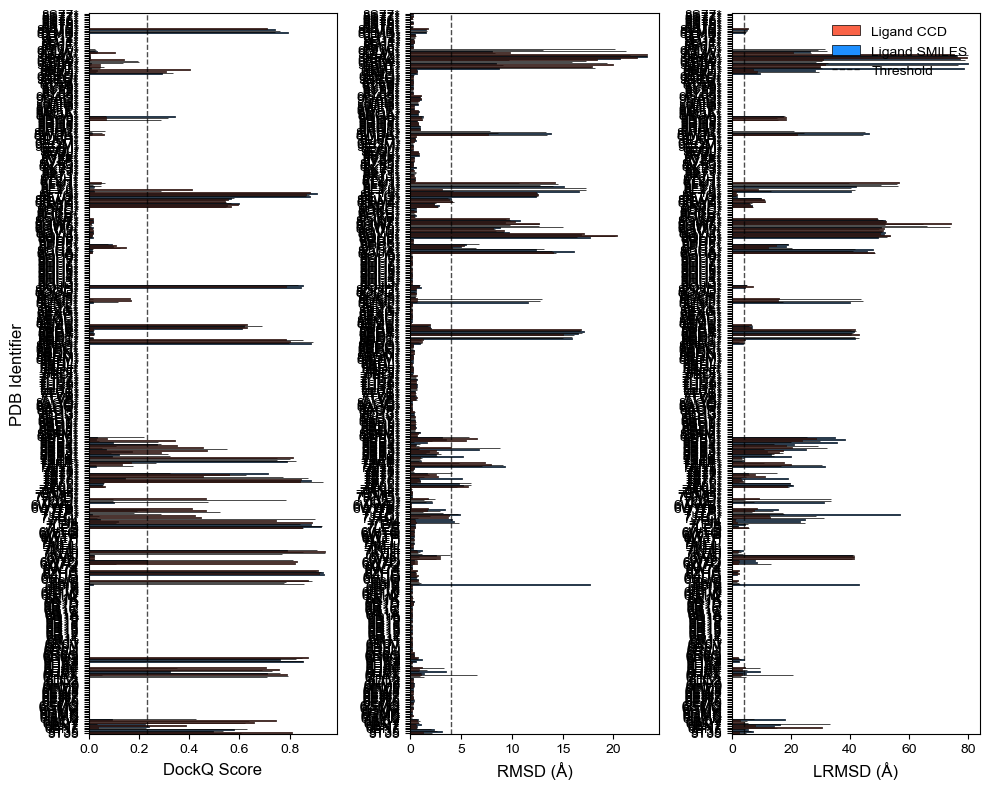

In [11]:
fig, axes = plot_horizontal_bars(
    df_af3,
    metrics=[
        ('SMILES_DOCKQ_SCORE', 'CCD_DOCKQ_SCORE', 'DockQ Score'),
        ('SMILES_RMSD', 'CCD_RMSD', 'RMSD (Å)'),
        ('SMILES_DOCKQ_LRMSD', 'CCD_DOCKQ_LRMSD', 'LRMSD (Å)')
    ],
    add_threshold=True,
    threshold_values=[0.23, 4, 4],
    show_y_labels_on_all=True,
    save=False
)

In [7]:
def plot_combined_horizontal_bars_bold(df,
                              metrics=[
                                  ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'DockQ Score'),
                                  ('SMILES RMSD', 'CCD RMSD', 'RMSD (Å)'),
                                  ('SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD', 'LRMSD (Å)')
                              ],
                              title=None,
                              add_threshold=False,
                              threshold_values=[0.23, 4.0, 4.0],
                              show_y_labels_on_all=False,
                              width=10,
                              height=8,
                              bar_height=0.3,
                              bar_spacing=0.05,
                              save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    # Number of metrics to plot
    n_metrics = len(metrics)
    n_pdbs = len(df_sorted)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_metrics, figsize=(width, height), sharey=not show_y_labels_on_all)
    
    # If only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Calculate offsets for the bars
    smiles_offset = -bar_height/2 - bar_spacing/2
    ccd_offset = bar_height/2 + bar_spacing/2
    
    # Create proper rectangle patches for the legend that match the bar appearance
    smiles_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_2, edgecolor='black', linewidth=0.5, label='Ligand SMILES')
    ccd_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_1, edgecolor='black', linewidth=0.5, label='Ligand CCD')
    legend_handles = [ccd_handle, smiles_handle]
    threshold_handle = None
    
    # Create arrays to track which PDBs meet the criteria for each metric
    # Initialize with False (not meeting criteria)
    meets_criteria = {
        'dockq': np.zeros(n_pdbs, dtype=bool),
        'rmsd': np.zeros(n_pdbs, dtype=bool),
        'lrmsd': np.zeros(n_pdbs, dtype=bool)
    }
    
    # Plot each metric
    for i, (smiles_col, ccd_col, axis_label) in enumerate(metrics):
        ax = axes[i]
        
        # Plot the SMILES bars
        ax.barh(
            y + smiles_offset, df_sorted[smiles_col], height=bar_height,
            color=color_2, edgecolor='black', linewidth=0.5
        )
        
        # Plot the CCD bars
        ax.barh(
            y + ccd_offset, df_sorted[ccd_col], height=bar_height,
            color=color_1, edgecolor='black', linewidth=0.5
        )
        
        # Add a vertical threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axvline(
                x=threshold_values[i], color='black', linestyle='--', 
                alpha=0.7, linewidth=1.0
            )
            # Store the first threshold handle we create for the legend
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Check which PDBs meet the criteria for this metric
        if 'DOCKQ' in smiles_col:
            if 'LRMSD' in smiles_col:
                # For LRMSD, values should be LOWER than threshold
                meets_criteria['lrmsd'] = (df_sorted[smiles_col] < threshold_values[i]) & (df_sorted[ccd_col] < threshold_values[i])
            else:
                # For DockQ, values should be HIGHER than threshold
                meets_criteria['dockq'] = (df_sorted[smiles_col] > threshold_values[i]) | (df_sorted[ccd_col] > threshold_values[i])
        elif 'RMSD' in smiles_col:
            # For RMSD, values should be LOWER than threshold
            meets_criteria['rmsd'] = (df_sorted[smiles_col] < threshold_values[i]) & (df_sorted[ccd_col] < threshold_values[i])
        
        # Set axis labels
        ax.set_xlabel(axis_label)
        
        # For the first subplot or if showing labels on all, set the y-axis label
        if i == 0:
            ax.set_ylabel('PDB Identifier')
        
        # Always set y-ticks
        ax.set_yticks(y)
        
        # Set y-tick labels conditionally
        if i == 0 or show_y_labels_on_all:
            # First set the regular labels
            ax.set_yticklabels(pdb_labels)
            
            # Then manually update the font weight for labels that meet criteria
            for j, label in enumerate(ax.get_yticklabels()):
                if ((i == 0 and meets_criteria['dockq'][j]) or 
                    (i == 1 and meets_criteria['rmsd'][j]) or 
                    (i == 2 and meets_criteria['lrmsd'][j])):
                    # Force matplotlib to use bold font
                    label.set_fontproperties(mpl.font_manager.FontProperties(weight='bold'))
        else:
            if show_y_labels_on_all:
                # If we want labels on all plots but using sharey
                ax.tick_params(axis='y', labelright=True, labelleft=False)
                ax.yaxis.set_tick_params(labelright=True, labelleft=False)
                ax.set_yticklabels(pdb_labels)
                
                # Then manually update the font weight for labels that meet criteria
                for j, label in enumerate(ax.get_yticklabels()):
                    if ((i == 0 and meets_criteria['dockq'][j]) or 
                        (i == 1 and meets_criteria['rmsd'][j]) or 
                        (i == 2 and meets_criteria['lrmsd'][j])):
                        # Force matplotlib to use bold font
                        label.set_fontproperties(mpl.font_manager.FontProperties(weight='bold'))
        
        # Set x-axis to start at 0
        ax.set_xlim(0.0)
        ax.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add threshold to legend if needed
    if add_threshold:
        from matplotlib.lines import Line2D
        threshold_line = Line2D([0], [0], color='black', linestyle='--', 
                               alpha=0.7, linewidth=1.0, label='Threshold')
        legend_handles.append(threshold_line)
    
    # Add legend to the last subplot
    axes[-1].legend(handles=legend_handles,
                  loc='upper right',
                  framealpha=0,  # Transparent background
                  edgecolor='none')  # No border
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            from datetime import datetime
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            # Create a filename based on the title or timestamp if no title
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            # Remove any special characters that might cause issues in filenames
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

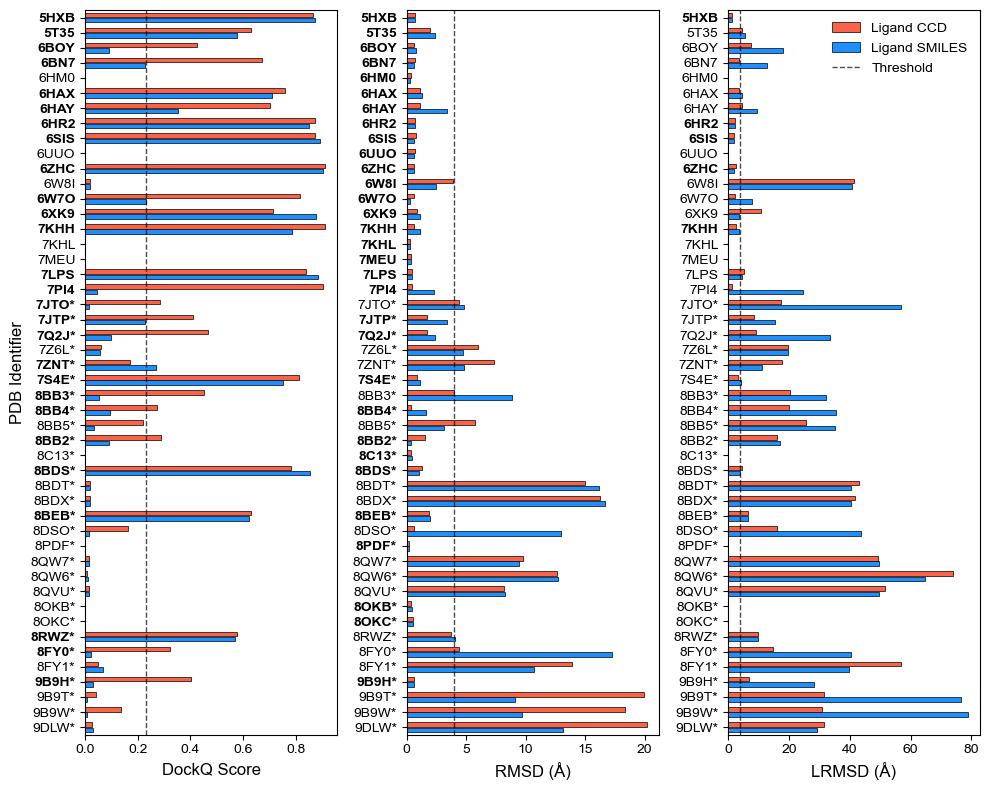

In [8]:
fig, axes = plot_combined_horizontal_bars_bold(
    df_af3,
    metrics=[
        ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'DockQ Score'),
        ('SMILES RMSD', 'CCD RMSD', 'RMSD (Å)'),
        ('SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD', 'LRMSD (Å)')
    ],
    add_threshold=True,
    threshold_values=[0.23, 4, 4],
    show_y_labels_on_all=True,
    save=False
)

# RMSD, iRMSD, LRMSD

In [9]:
def plot_rmsd_horizontal_bars(df,
                             x_label='RMSD (Å)',
                             title=None,
                             add_threshold=False,
                             threshold_value=2.0,
                             width=12,
                             height=14, 
                             bar_height=0.18,
                             bar_spacing=0.08,
                             save=False):
    """
    Plot horizontal bar charts comparing RMSD, DOCKQ iRMSD, and DOCKQ LRMSD metrics for both SMILES and CCD.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the metrics to plot
    x_label : str
        Label for the x-axis (values axis)
    title : str, optional
        Title for the plot
    add_threshold : bool
        Whether to add a threshold line
    threshold_value : float
        Value for the threshold line
    width, height : float
        Figure dimensions
    bar_height : float
        Height of each bar
    bar_spacing : float
        Spacing between bars
    save : bool
        Whether to save the plot
    """
    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with two subplots (SMILES on left, CCD on right)
    fig, (ax_smiles, ax_ccd) = plt.subplots(1, 2, figsize=(width, height), sharey=False)
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Define all possible metrics and their colors - already in the correct order
    all_metrics = [
        # SMILES metrics
        ('SMILES RMSD', color_2, 'RMSD', ax_smiles, 'Complex (SMILES)'),
        ('SMILES DOCKQ iRMSD', color_4, 'iRMSD', ax_smiles, 'Complex (SMILES)'),
        ('SMILES DOCKQ LRMSD', color_6, 'LRMSD', ax_smiles, 'Complex (SMILES)'),
        # CCD metrics
        ('CCD RMSD', color_1, 'RMSD', ax_ccd, 'Complex (CCD)'),
        ('CCD DOCKQ iRMSD', color_3, 'iRMSD', ax_ccd, 'Complex (CCD)'),
        ('CCD DOCKQ LRMSD', color_5, 'LRMSD', ax_ccd, 'Complex (CCD)')
    ]
    
    # Alternative column names
    alt_columns = {
        'SMILES DOCKQ iRMSD': ['SMILES iRMSD'],
        'SMILES DOCKQ LRMSD': ['SMILES LRMSD'],
        'CCD DOCKQ iRMSD': ['CCD iRMSD', 'CCD DOCKQ iRMSD '],  # Note the space at the end
        'CCD DOCKQ LRMSD': ['CCD LRMSD']
    }
    
    # Updated positions for each metric type to match legend order (RMSD first, then iRMSD, then LRMSD)
    positions = {
        'RMSD': 2,    # Will be the top bar when y-axis is inverted
        'iRMSD': 1,   # Will be the middle bar
        'LRMSD': 0    # Will be the bottom bar when y-axis is inverted
    }
    
    # Define exact positions for each bar type to ensure consistent spacing
    bar_positions = {}
    for metric_type, position in positions.items():
        # Calculate exact position
        bar_positions[metric_type] = (position - 1) * (bar_height + bar_spacing)
    
    # Create legend handles for each subplot
    legend_handles_smiles = []
    legend_handles_ccd = []
    
    # Plot each metric if available
    for col, color, label_type, ax, prefix in all_metrics:
        # Check if column exists, if not try alternative names
        if col not in df.columns:
            found = False
            if col in alt_columns:
                for alt_col in alt_columns[col]:
                    if alt_col in df.columns:
                        col = alt_col
                        found = True
                        break
            if not found:
                continue
        
        # Get position based on metric type
        bar_position = bar_positions[label_type]
        
        # Plot the horizontal bar
        bars = ax.barh(
            y + bar_position, 
            df_sorted[col], 
            height=bar_height,
            color=color, 
            edgecolor='black', 
            linewidth=edge_width,
            label=f"{prefix} {label_type}"
        )
        
        # Add to appropriate legend handles
        if ax == ax_smiles:
            legend_handles_smiles.append(bars)
        else:
            legend_handles_ccd.append(bars)
    
    # Add threshold if requested
    if add_threshold:
        threshold_line_smiles = ax_smiles.axvline(
            x=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        threshold_line_ccd = ax_ccd.axvline(
            x=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles_smiles.append(threshold_line_smiles)
        legend_handles_ccd.append(threshold_line_ccd)
    
    # Set axis labels and titles
    ax_smiles.set_xlabel(x_label)
    ax_ccd.set_xlabel(x_label)
    
    # Reverse y-axis so earliest structures are at the top
    ax_smiles.invert_yaxis()
    ax_ccd.invert_yaxis()  # Also invert the right subplot
    
    # Set y-ticks on both subplots
    ax_smiles.set_yticks(y)
    ax_smiles.set_yticklabels(pdb_labels)
    ax_ccd.set_yticks(y)
    ax_ccd.set_yticklabels(pdb_labels)
    
    # Set x-axis to start at 0
    ax_smiles.set_xlim(0)
    ax_ccd.set_xlim(0)
    
    # Set y-axis limits
    ax_smiles.set_ylim(-0.5, len(df_sorted) - 0.5)
    ax_ccd.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add legends
    if legend_handles_smiles:
        ax_smiles.legend(
            handles=legend_handles_smiles,
            loc='upper right',
            framealpha=0,  # Transparent background
            edgecolor='none'  # No border
        )
    
    if legend_handles_ccd:
        ax_ccd.legend(
            handles=legend_handles_ccd,
            loc='upper right',
            framealpha=0,  # Transparent background
            edgecolor='none'  # No border
        )
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{title.lower().replace(' ', '_')}_horizontal" if title else f"plot_horizontal_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_smiles, ax_ccd)

(<Figure size 800x1200 with 2 Axes>,
 (<Axes: xlabel='RMSD (Å)'>, <Axes: xlabel='RMSD (Å)'>))

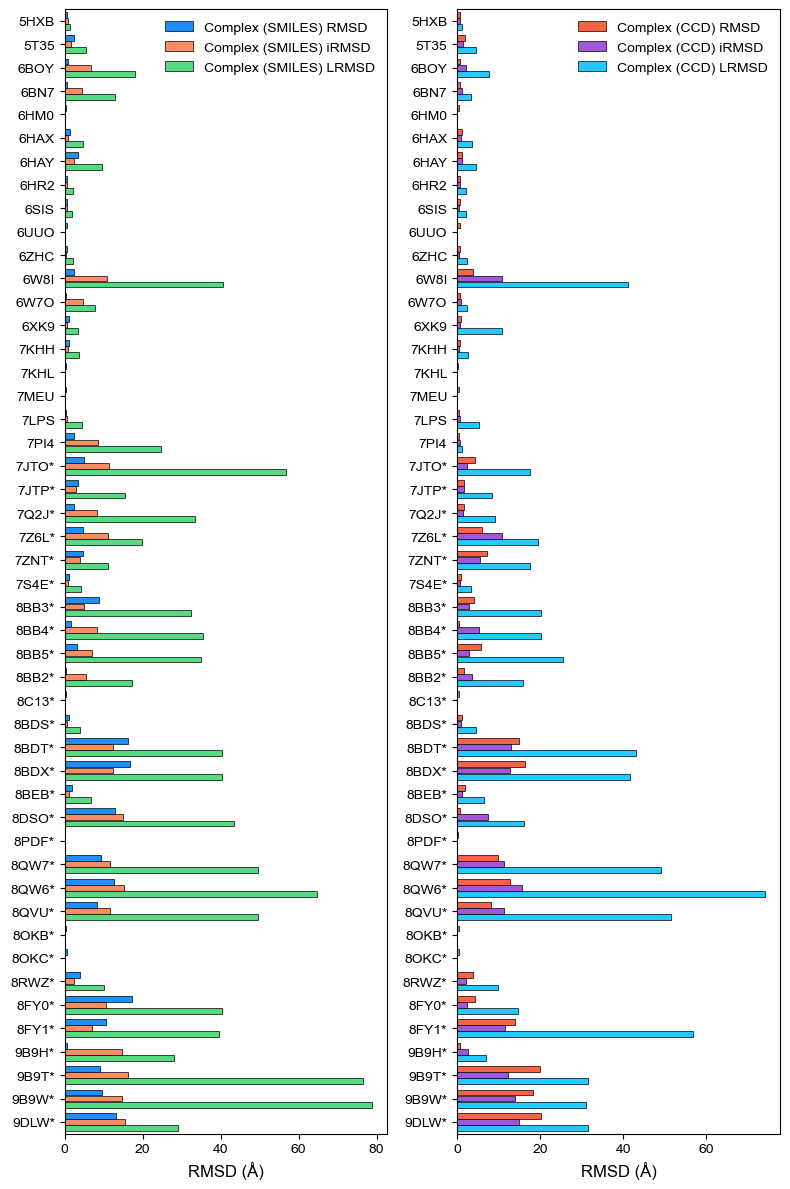

In [10]:
plot_rmsd_horizontal_bars(df_af3, save=False, width=8, height=12, bar_spacing=0.01, bar_height=0.25)

# pTM and ipTM

In [11]:
def plot_ptm_iptm_horizontal_bars(df,
                           title=None,
                           add_threshold=False,
                           threshold_value=0.5,
                           width=12,
                           height=14, 
                           bar_height=0.18,
                           bar_spacing=0.08,
                           save=False):
    """
    Plot horizontal bar charts comparing PTM and iPTM metrics for both SMILES and CCD.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the metrics to plot
    x_label : str
        Label for the x-axis (values axis)
    title : str, optional
        Title for the plot
    add_threshold : bool
        Whether to add a threshold line
    threshold_value : float
        Value for the threshold line
    width, height : float
        Figure dimensions
    bar_height : float
        Height of each bar
    bar_spacing : float
        Spacing between bars
    save : bool
        Whether to save the plot
    """
    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with two subplots (PTM on left, iPTM on right)
    fig, (ax_ptm, ax_iptm) = plt.subplots(1, 2, figsize=(width, height), sharey=True)
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Define the metrics to plot in each subplot - keep original order for legend
    ptm_metrics = [
        ('CCD PTM', color_1, 'Ligand CCD'),    # First in legend
        ('SMILES PTM', color_2, 'Ligand SMILES')  # Second in legend
    ]
    
    iptm_metrics = [
        ('CCD IPTM', color_1, 'Ligand CCD'),      # First in legend
        ('SMILES IPTM', color_2, 'Ligand SMILES')  # Second in legend
    ]
    
    # Create legend handles for each subplot
    legend_handles_ptm = []
    legend_handles_iptm = []
    
    # Define fixed positions for SMILES and CCD bars - reverse the positions to swap the order
    bar_positions = {
        'Ligand SMILES': -0.5 * (bar_height + bar_spacing),  # SMILES on top (when inverted)
        'Ligand CCD': 0.5 * (bar_height + bar_spacing)       # CCD on bottom (when inverted)
    }
    
    # Plot PTM metrics
    for col, color, label in ptm_metrics:
        if col in df.columns:
            # Get bar position from the dictionary
            bar_position = bar_positions[label]
            
            # Plot the horizontal bar
            bars = ax_ptm.barh(
                y + bar_position, 
                df_sorted[col], 
                height=bar_height,
                color=color, 
                edgecolor='black', 
                linewidth=edge_width,
                label=label
            )
            
            # Add to legend handles
            legend_handles_ptm.append(bars)
    
    # Plot IPTM metrics
    for col, color, label in iptm_metrics:
        if col in df.columns:
            # Get bar position from the dictionary
            bar_position = bar_positions[label]
            
            # Plot the horizontal bar
            bars = ax_iptm.barh(
                y + bar_position, 
                df_sorted[col], 
                height=bar_height,
                color=color, 
                edgecolor='black', 
                linewidth=edge_width,
                label=label
            )
            
            # Add to legend handles
            legend_handles_iptm.append(bars)
    
    # Add threshold if requested
    if add_threshold:
        threshold_line_ptm = ax_ptm.axvline(
            x=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        threshold_line_iptm = ax_iptm.axvline(
            x=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles_ptm.append(threshold_line_ptm)
        legend_handles_iptm.append(threshold_line_iptm)
    
    # Set axis labels and titles
    ax_ptm.set_xlabel("pTM")
    ax_iptm.set_xlabel("ipTM")
    
    # Reverse y-axis so earliest structures are at the top
    ax_ptm.invert_yaxis()
    ax_iptm.invert_yaxis()
    
    # Set y-ticks on both subplots
    ax_ptm.set_yticks(y)
    ax_ptm.set_yticklabels(pdb_labels)
    ax_iptm.set_yticks(y)
    ax_iptm.set_yticklabels(pdb_labels)
    plt.setp(ax_ptm.get_yticklabels(), visible=True)
    plt.setp(ax_iptm.get_yticklabels(), visible=True)
    ax_iptm.tick_params(labelleft=True)
    
    # Set x-axis to start at 0
    ax_ptm.set_xlim(0,1.2)
    ax_iptm.set_xlim(0,1.2)
    
    # Set y-axis limits
    ax_ptm.set_ylim(-0.5, len(df_sorted) - 0.5)
    ax_iptm.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add legends in the specified order
    if legend_handles_ptm:
        ax_ptm.legend(
            handles=legend_handles_ptm,
            loc='lower right',
            framealpha=0,  # Transparent background
            edgecolor='none'  # No border
        )
    
    if legend_handles_iptm:
        ax_iptm.legend(
            handles=legend_handles_iptm,
            loc='lower right',
            framealpha=0,  # Transparent background
            edgecolor='none'  # No border
        )
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{title.lower().replace(' ', '_')}_horizontal" if title else f"ptm_iptm_horizontal_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_ptm, ax_iptm)

(<Figure size 800x1200 with 2 Axes>,
 (<Axes: xlabel='pTM'>, <Axes: xlabel='ipTM'>))

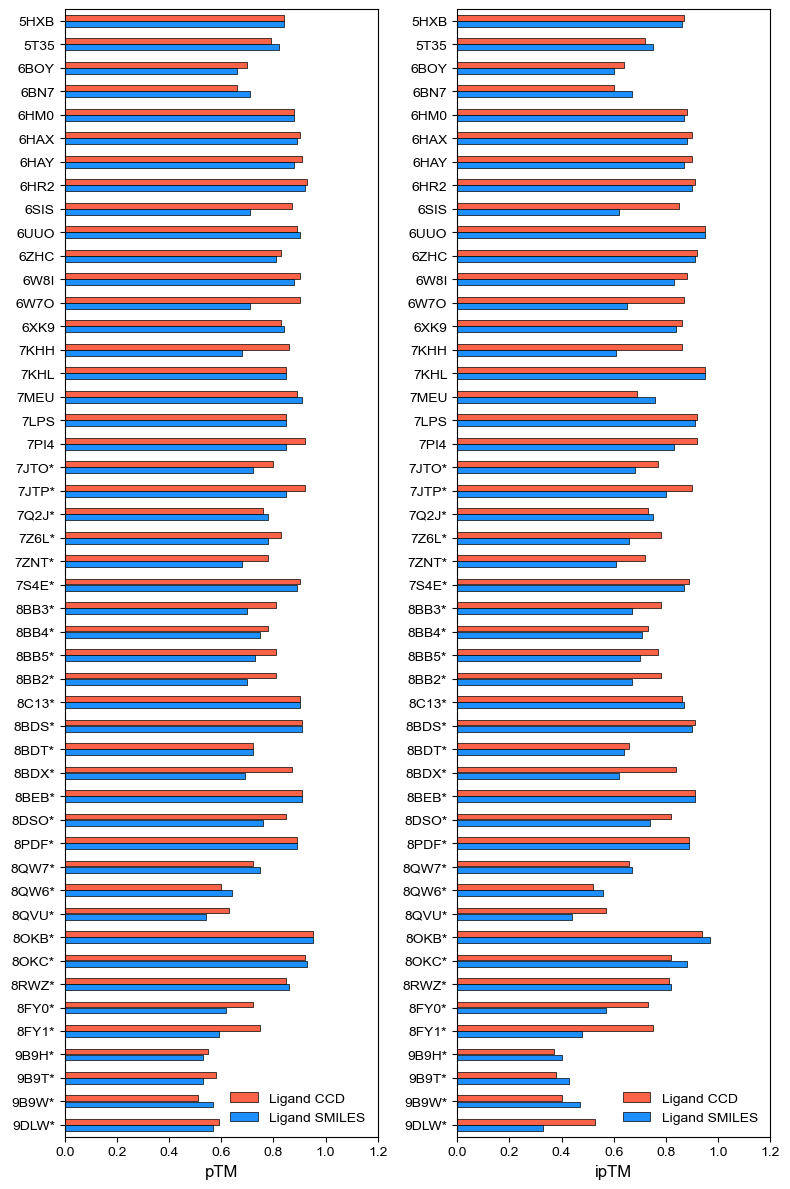

In [12]:
plot_ptm_iptm_horizontal_bars(df_af3, save=False, width=8, height=12, bar_spacing=0.01, bar_height=0.25)

# Fraction Disordered

In [65]:
def plot_fraction_disordered_horizontal_bars(df,
                                            title=None,
                                            add_threshold=False,
                                            threshold_value=0.5,
                                            width=12,
                                            height=14, 
                                            bar_height=0.18,
                                            bar_spacing=0.08,
                                            save=False):
    """
    Plot horizontal bar charts comparing fraction of disordered residues for both CCD and SMILES.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the disordered fraction metrics to plot
    title : str, optional
        Title for the plot
    add_threshold : bool
        Whether to add a threshold line
    threshold_value : float
        Value for the threshold line
    width, height : float
        Figure dimensions
    bar_height : float
        Height of each bar
    bar_spacing : float
        Spacing between bars
    save : bool
        Whether to save the plot
    """
    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with a single subplot
    fig, ax = plt.subplots(figsize=(width, height))
    
    # Set up y-axis positions (one position per PDB)
    y = np.arange(n_pdbs)
    
    # Define the metrics to plot - CCD first, then SMILES
    metrics = [
        ('CCD FRACTION DISORDERED', color_1, 'Ligand CCD'),    # First in legend and bars
        ('SMILES FRACTION DISORDERED', color_2, 'Ligand SMILES')  # Second in legend and bars
    ]
    
    # Create legend handles
    legend_handles = []
    
    # SWAPPED POSITIONS - CCD should be on the left when looking at the chart
    # With the y-axis inverted, positive offset puts bars on the left
    ccd_position = 0.5 * (bar_height + bar_spacing)     # CCD on left when viewed
    smiles_position = -0.5 * (bar_height + bar_spacing)  # SMILES on right when viewed
    
    # Plot metrics
    for i, (col, color, label) in enumerate(metrics):
        if col in df.columns:
            # Calculate bar position - CCD is first (left), SMILES is second (right)
            bar_position = ccd_position if i == 0 else smiles_position
            
            # Plot the horizontal bar
            bars = ax.barh(
                y + bar_position, 
                df_sorted[col], 
                height=bar_height,
                color=color, 
                edgecolor='black', 
                linewidth=edge_width,
                label=label
            )
            
            # Add to legend handles
            legend_handles.append(bars)
    
    # Add threshold if requested
    if add_threshold:
        threshold_line = ax.axvline(
            x=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles.append(threshold_line)
    
    # Set axis labels and titles
    ax.set_xlabel("Fraction Disordered")
    
    # Reverse y-axis so earliest structures are at the top
    ax.invert_yaxis()
    
    # Set y-ticks
    ax.set_yticks(y)
    ax.set_yticklabels(pdb_labels)
    
    # Set x-axis to start at 0 and end at 1 (fractions)
    ax.set_xlim(0, 1)
    
    # Set y-axis limits
    ax.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add legend in the specified order
    if legend_handles:
        ax.legend(
            handles=legend_handles,
            loc='upper right',
            framealpha=0,  # Transparent background
            edgecolor='none'  # No border
        )
    
    # Add title if provided
    if title:
        ax.set_title(title)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{title.lower().replace(' ', '_')}_horizontal" if title else f"fraction_disordered_horizontal_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, ax

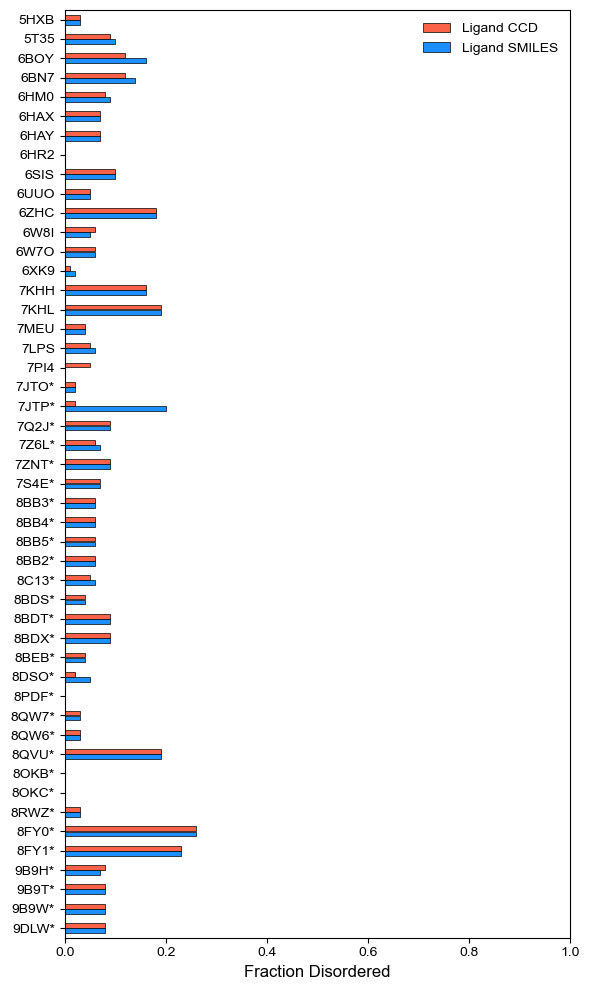

In [68]:
# Example usage
fig, ax = plot_fraction_disordered_horizontal_bars(df_af3, 
                                                  title=None,
                                                  add_threshold=False,
                                                  threshold_value=0,
                                                  save=False,
                                                  width=6,
                                                  height=10,
                                                  bar_height=0.25,
                                                  bar_spacing=0.01)

# RMSD by POI and E3 Ligase

In [13]:
# Convert PDB_ID to the same type in both dataframes before joining
df_af3['PDB_ID'] = df_af3['PDB_ID'].astype(str)
df_poi_e3_rmsd['PDB_ID'] = df_poi_e3_rmsd['PDB_ID'].astype(str)

# Now join the dataframes with matching types
df_complex_poi_e3_rmsd = df_poi_e3_rmsd.merge(df_af3[['PDB_ID','SMILES RMSD', 'CCD RMSD']], on='PDB_ID', how='left')

In [14]:
df_complex_poi_e3_rmsd.tail()

,PDB_ID,PDB_LINK,PDB_RELEASE_DATE,SMILES RMSD POI,SMILES RMSD E3 LIGASE,CCD RMSD POI,CCD RMSD E3 LIGASE,SMILES RMSD,CCD RMSD
43,8FY1,8FY1,2024-04-10,0.297,0.285,0.298,0.309,10.706,13.894
44,9B9H,9B9H,2024-11-06,0.239,0.645,0.232,0.644,0.622,0.588
45,9B9T,9B9T,2024-11-06,0.222,0.610,0.185,0.537,9.123,19.931
46,9B9W,9B9W,2024-11-06,0.188,0.564,0.219,0.583,9.680,18.369
47,9DLW,9DLW,2024-11-06,0.227,0.620,0.232,0.648,13.105,20.166


In [15]:
def plot_combined_horizontal(df,
                             metrics=[
                                 ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'DockQ Score'),
                                 ('SMILES RMSD', 'CCD RMSD', 'RMSD (Å)'),
                                 ('SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD', 'LRMSD (Å)')
                             ],
                             title=None,
                             add_threshold=False,
                             threshold_values=[0.23, 0.0, 0.0],
                             x_labels_on_all=False,
                             width=10,
                             height=9,
                             bar_width=0.3,  # Width of each bar
                             bar_spacing=0.05,  # Space between SMILES and CCD bars
                             save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    # Number of metrics to plot
    n_metrics = len(metrics)
    n_pdbs = len(df_sorted)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(width, height), sharex=not x_labels_on_all)
    
    # If only one metric, axes won't be an array
    if n_metrics == 1:
        axes = [axes]
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Calculate offsets for the bars - SWAPPED THESE LINES
    ccd_offset = -bar_width/2 - bar_spacing/2  # This was previously smiles_offset
    smiles_offset = bar_width/2 + bar_spacing/2  # This was previously ccd_offset
    
    # Create proper rectangle patches for the legend that match the bar appearance
    smiles_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_2, edgecolor='black', linewidth=edge_width, label='Ligand SMILES')
    ccd_handle = plt.Rectangle((0, 0), 1, 1, facecolor=color_1, edgecolor='black', linewidth=edge_width, label='Ligand CCD')
    legend_handles = [ccd_handle, smiles_handle]
    threshold_handle = None
    
    # Plot each metric
    for i, (smiles_col, ccd_col, axis_label) in enumerate(metrics):
        ax = axes[i]
        
        # Plot the SMILES bars
        ax.bar(
            x + smiles_offset, df_sorted[smiles_col], width=bar_width,
            color=color_2, edgecolor='black', linewidth=edge_width
        )
        
        # Plot the CCD bars
        ax.bar(
            x + ccd_offset, df_sorted[ccd_col], width=bar_width,
            color=color_1, edgecolor='black', linewidth=edge_width
        )
        
        # Add a horizontal threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axhline(
                y=threshold_values[i], color='black', linestyle='--', 
                alpha=grid_alpha, linewidth=line_width,
                label=None  # Don't add label here, we'll handle it in the legend
            )
            # Store the first threshold handle we create for the legend
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Set axis labels
        ax.set_ylabel(axis_label)
        
        # Always set x-ticks
        ax.set_xticks(x)
        
        # Set x-tick labels based on the option
        if x_labels_on_all or i == n_metrics - 1:  # Last subplot or all subplots
            ax.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
        else:
            ax.set_xticklabels([])  # Empty labels for non-last subplots
        
        # Set x-axis label only on the last subplot
        if i == n_metrics - 1:
            ax.set_xlabel('PDB Identifier')
        
        # Set y-axis to start at 0
        ax.set_ylim(0.0, 2.0)
        ax.set_xlim(-0.5, len(df_sorted) - 0.5)
    
    # Add legend only to the first subplot
    if legend_handles:
        # If we need to add a threshold to the legend but none was created
        # (e.g., all threshold values were None), create a dummy line for the legend
        if add_threshold:
            if threshold_handle is None:
                # Create an invisible line just for the legend
                threshold_handle = axes[0].axhline(
                    y=0, color='black', linestyle='--', 
                    alpha=grid_alpha, linewidth=line_width,
                    visible=False
                )
                    
        axes[0].legend(handles=legend_handles,
                      loc='upper left',
                      framealpha=0, 
                      edgecolor='none') 
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

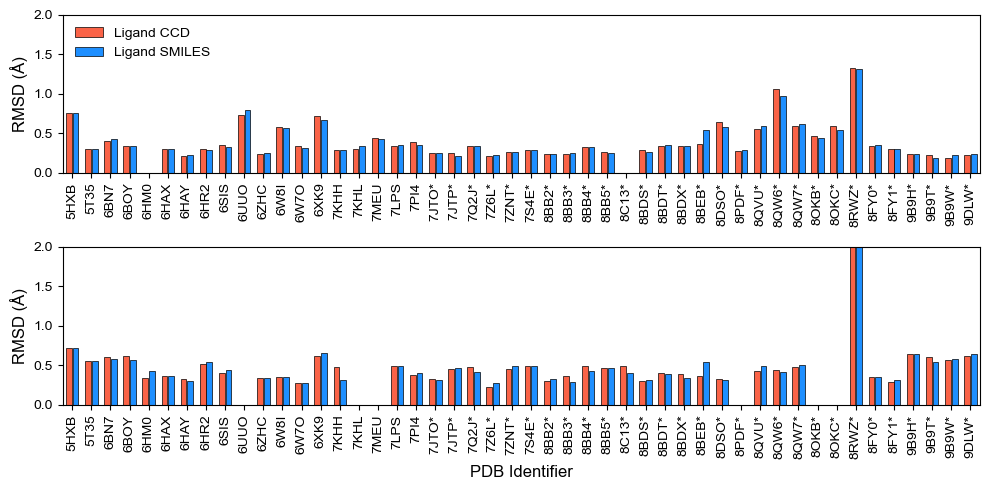

In [16]:
fig, axes = plot_combined_horizontal(
    df_poi_e3_rmsd,
    metrics=[
        ('CCD RMSD POI', 'SMILES RMSD POI',  'RMSD (Å)'),
        ('CCD RMSD E3 LIGASE', 'SMILES RMSD E3 LIGASE', 'RMSD (Å)'),
    ],
    add_threshold=True,
    threshold_values=[4, 4],
    x_labels_on_all=True,
    width=10,
    height=5,
    save=False
)

In [17]:
df_complex_poi_e3_rmsd_high = df_complex_poi_e3_rmsd[(df_complex_poi_e3_rmsd['SMILES RMSD'] > 4.0) | (df_complex_poi_e3_rmsd['CCD RMSD'] > 4.0)]

In [18]:
def plot_stacked_and_independent_bars(df,
                             independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
                             stacked_metrics=[(('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'), 
                                              ('CCD RMSD POI', 'CCD RMSD E3 LIGASE'))],
                             y_label='RMSD (Å)',
                             title=None,
                             add_threshold=False,
                             threshold_value=2.0,
                             width=12,
                             height=10,
                             bar_width=0.2,
                             bar_spacing=0.05,
                             save=False):

    # Sort by release date
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    n_pdbs = len(df_sorted)
    
    # Create figure with two subplots (SMILES on top, CCD on bottom)
    fig, (ax_smiles, ax_ccd) = plt.subplots(2, 1, figsize=(width, height), sharex=True)
    
    # Set up x-axis positions (one position per PDB)
    x = np.arange(n_pdbs)
    
    # Calculate number of bar sets and their positions
    n_independent_sets = 1  # Now we're only plotting one type per subplot
    n_stacked_sets = 1
    n_total_sets = n_independent_sets + n_stacked_sets
    
    # Calculate the total width needed for all bars for a single PDB
    total_width = n_total_sets * bar_width * 0.5 + (n_total_sets - 1) * bar_spacing
    
    # Calculate starting offset to center the bars
    start_offset = -total_width / 2
    
    
    # SMILES subplot (top)
    current_offset = start_offset
    legend_handles_smiles = []
    
    # Plot SMILES independent metrics
    for i, (smiles_col, _) in enumerate(independent_metrics):
        # SMILES bar
        smiles_bars = ax_smiles.bar(
            x + current_offset, 
            df_sorted[smiles_col], 
            width=bar_width,
            color=color_2, 
            edgecolor='black', 
            linewidth=edge_width,
            label="Complex (SMILES)"
        )
        legend_handles_smiles.append(smiles_bars)
        
        # Move to next position
        current_offset += bar_width  + bar_spacing
    
    # Plot SMILES stacked metrics
    for i, (smiles_cols, _) in enumerate(stacked_metrics):
        # Colors for the stacked bars
        smiles_colors = [color_4, color_6]
        
        # SMILES stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(smiles_cols):
            # Labels
            if j == 0:
                custom_label = "POI (SMILES)"
            else:
                custom_label = "E3 Ligase (SMILES)"
            bars = ax_smiles.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=smiles_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            legend_handles_smiles.append(bars)
            bottom += df_sorted[col]
    
    # CCD subplot (bottom)
    current_offset = start_offset
    legend_handles_ccd = []
    
    # Plot CCD independent metrics
    for i, (_, ccd_col) in enumerate(independent_metrics):
        # CCD bar
        ccd_bars = ax_ccd.bar(
            x + current_offset, 
            df_sorted[ccd_col], 
            width=bar_width,
            color=color_1, 
            edgecolor='black', 
            linewidth=edge_width,
            label="Complex (CCD)"
        )
        legend_handles_ccd.append(ccd_bars)
        
        # Move to next position
        current_offset += bar_width + bar_spacing
    
    # Plot CCD stacked metrics
    for i, (_, ccd_cols) in enumerate(stacked_metrics):
        # Colors for the stacked bars
        ccd_colors = [color_3, color_5]
        
        # CCD stacked bars
        bottom = np.zeros(n_pdbs)
        for j, col in enumerate(ccd_cols):
            # Labels
            if j == 0:
                custom_label = "POI (CCD)"
            else:
                custom_label = "E3 Ligase (CCD)"
            bars = ax_ccd.bar(
                x + current_offset, 
                df_sorted[col], 
                width=bar_width,
                bottom=bottom,
                color=ccd_colors[j], 
                edgecolor='black', 
                linewidth=edge_width,
                label=custom_label
            )
            legend_handles_ccd.append(bars)
            bottom += df_sorted[col]
    
    # Add threshold if requested
    if add_threshold:
        threshold_line_smiles = ax_smiles.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        threshold_line_ccd = ax_ccd.axhline(
            y=threshold_value, color='black', linestyle='--', 
            alpha=grid_alpha, linewidth=line_width,
            label='Threshold'
        )
        legend_handles_smiles.append(threshold_line_smiles)
        legend_handles_ccd.append(threshold_line_ccd)
    
    # Set axis labels and ticks
    ax_smiles.set_ylabel(y_label)
    ax_ccd.set_ylabel(y_label)
    ax_ccd.set_xlabel('PDB Identifier')
    
    # Set x-ticks on top and bottom subplot
    ax_smiles.set_xticks(x)
    ax_smiles.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    ax_smiles.tick_params(axis='x', labelrotation=x_axis_rotation, labelbottom=True)

    ax_ccd.set_xticks(x)
    ax_ccd.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
    
    # Set y-axis to start at 0
    ax_smiles.set_ylim(0.0)
    ax_ccd.set_ylim(0.0)
    
    # Set x-axis limits
    ax_smiles.set_xlim(-0.5, len(df_sorted) - 0.5)
    ax_ccd.set_xlim(-0.5, len(df_sorted) - 0.5)
    
    # Add legends
    ax_smiles.legend(
        handles=legend_handles_smiles,
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    ax_ccd.legend(
        handles=legend_handles_ccd,
        loc='upper left',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    # Add title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_smiles, ax_ccd)

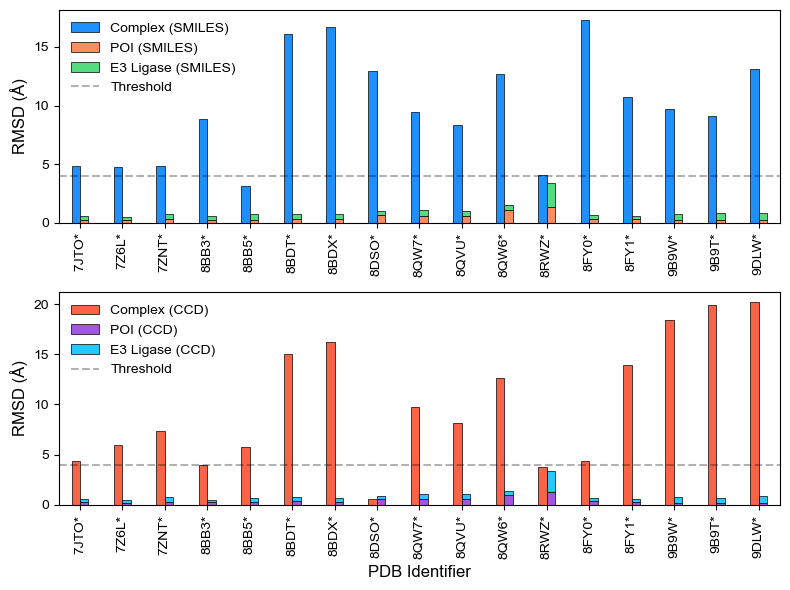

In [19]:
fig, ax = plot_stacked_and_independent_bars(
    df_complex_poi_e3_rmsd_high,
    independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
    stacked_metrics=[(
        ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
        ('CCD RMSD POI', 'CCD RMSD E3 LIGASE')
    )],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=8,
    height=6,
    save=False,
    bar_width=0.2,
    bar_spacing=0.0
)

In [20]:
remove_ids_smiles = ['8BB5']
df_complex_poi_e3_rmsd_high_smiles = df_complex_poi_e3_rmsd_high[~df_complex_poi_e3_rmsd_high['PDB_ID'].isin(remove_ids_smiles)]

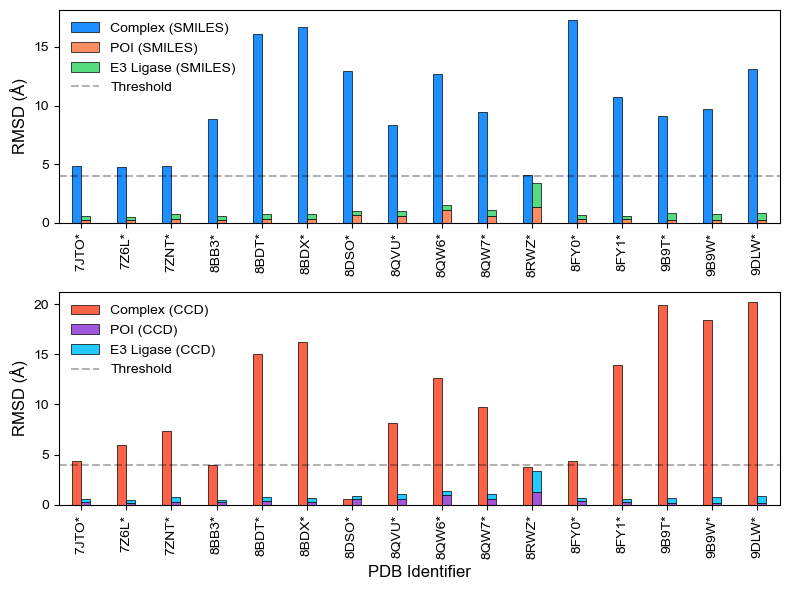

In [21]:
fig, ax = plot_stacked_and_independent_bars(
    df_complex_poi_e3_rmsd_high_smiles,
    independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
    stacked_metrics=[(
        ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
        ('CCD RMSD POI', 'CCD RMSD E3 LIGASE')
    )],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=8,
    height=6,
    save=False,
    bar_width=0.2,
    bar_spacing=0.0
)

In [22]:
remove_ids_ccd = ['8DSO', '8BB3', '8RWZ']

df_complex_poi_e3_rmsd_high_ccd = df_complex_poi_e3_rmsd_high[~df_complex_poi_e3_rmsd_high['PDB_ID'].isin(remove_ids_ccd)]

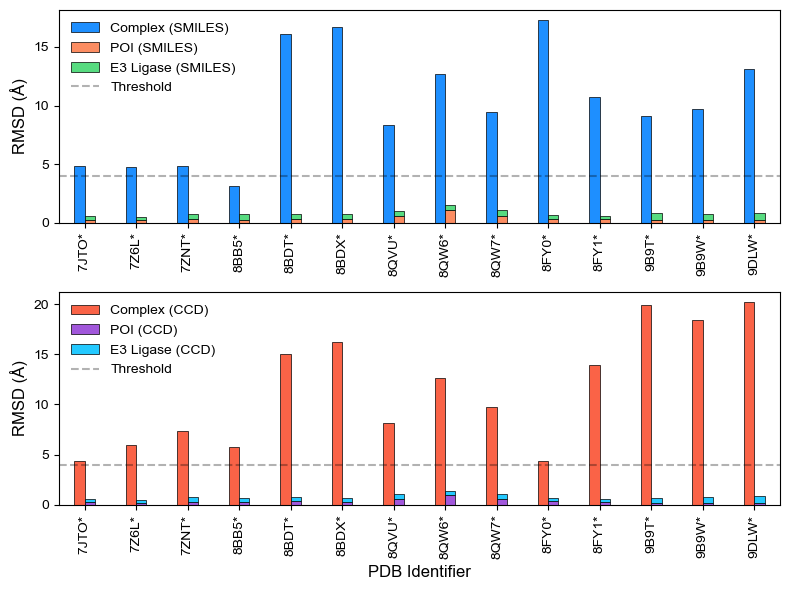

In [23]:
fig, ax = plot_stacked_and_independent_bars(
    df_complex_poi_e3_rmsd_high_ccd,
    independent_metrics=[('SMILES RMSD', 'CCD RMSD')],
    stacked_metrics=[(
        ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
        ('CCD RMSD POI', 'CCD RMSD E3 LIGASE')
    )],
    y_label='RMSD (Å)',
    add_threshold=True,
    threshold_value=4.0,
    width=8,
    height=6,
    save=False,
    bar_width=0.2,
    bar_spacing=0.0
)

In [24]:
def plot_mean_rmsd_vertical(df, 
                           title=None,
                           width=10,
                           height=6,
                           bar_width=0.6,
                           save=False):
    """
    Plot vertical bar charts comparing mean RMSD metrics for full complex, POI, and E3 ligase.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the RMSD metrics to plot
    title : str, optional
        Title for the plot
    width, height : float
        Figure dimensions
    bar_width : float
        Width of each bar
    save : bool
        Whether to save the plot
    """
    # Calculate mean values for each RMSD column
    mean_values = {
        # SMILES metrics
        'SMILES RMSD': df['SMILES RMSD'].mean(),
        'SMILES RMSD POI': df['SMILES RMSD POI'].mean(),
        'SMILES RMSD E3 LIGASE': df['SMILES RMSD E3 LIGASE'].mean(),
        
        # CCD metrics
        'CCD RMSD': df['CCD RMSD'].mean(),
        'CCD RMSD POI': df['CCD RMSD POI'].mean(),
        'CCD RMSD E3 LIGASE': df['CCD RMSD E3 LIGASE'].mean()
    }
    
    # Create figure with two subplots (SMILES on left, CCD on right)
    fig, (ax_smiles, ax_ccd) = plt.subplots(1, 2, figsize=(width, height), sharey=True)
    
    # Define the metrics to plot in each subplot
    smiles_metrics = [
        ('SMILES RMSD', color_2, 'Complex (SMILES)'),
        ('SMILES RMSD POI', color_4, 'POI (SMILES)'),
        ('SMILES RMSD E3 LIGASE', color_6, 'E3 Ligase (SMILES)')
    ]
    
    ccd_metrics = [
        ('CCD RMSD', color_1, 'Complex (CCD)'),
        ('CCD RMSD POI', color_3, 'POI (CCD)'),
        ('CCD RMSD E3 LIGASE', color_5, 'E3 Ligase (CCD)')
    ]
    
    # Set up x-positions for the bars
    x_pos = np.arange(len(smiles_metrics))
    
    # Plot SMILES metrics
    smiles_bars = []
    smiles_labels = []
    for i, (metric, color, label) in enumerate(smiles_metrics):
        bar = ax_smiles.bar(
            i, 
            mean_values[metric], 
            width=bar_width,
            color=color, 
            edgecolor='black', 
            linewidth=edge_width,
            label=f"{label}"
        )
        smiles_bars.append(bar)
        smiles_labels.append(label)
        
        # Add value label on top of the bar
        ax_smiles.text(
            i, 
            mean_values[metric] + 0.05, 
            f"{mean_values[metric]:.3f}", 
            ha='center', 
            va='bottom',
            fontsize=9
        )
    
    # Plot CCD metrics
    ccd_bars = []
    ccd_labels = []
    for i, (metric, color, label) in enumerate(ccd_metrics):
        bar = ax_ccd.bar(
            i, 
            mean_values[metric], 
            width=bar_width,
            color=color, 
            edgecolor='black', 
            linewidth=edge_width,
            label=f"{label}"
        )
        ccd_bars.append(bar)
        ccd_labels.append(label)
        
        # Add value label on top of the bar
        ax_ccd.text(
            i, 
            mean_values[metric] + 0.05, 
            f"{mean_values[metric]:.3f}", 
            ha='center', 
            va='bottom',
            fontsize=9
        )
    
    # Remove x-ticks and labels
    ax_smiles.set_xticks([])
    ax_ccd.set_xticks([])
    
    # Set y-axis label (only on the left subplot)
    ax_smiles.set_ylabel("Mean RMSD (Å)")
    
    # Set y-axis to start at 0
    y_max = max(list(mean_values.values())) * 1.2  # Add 20% padding
    ax_smiles.set_ylim(0, y_max)
    ax_ccd.set_ylim(0, y_max)
    
    # Add legends
    ax_smiles.legend(
        handles=smiles_bars,
        loc='upper right',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    ax_ccd.legend(
        handles=ccd_bars,
        loc='upper right',
        framealpha=0,  # Transparent background
        edgecolor='none'  # No border
    )
    
    plt.tight_layout()
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
        plt.subplots_adjust(top=0.85)  # Adjust for title space
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            
            from datetime import datetime
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"{title.lower().replace(' ', '_')}" if title else f"mean_rmsd_vertical_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, (ax_smiles, ax_ccd)

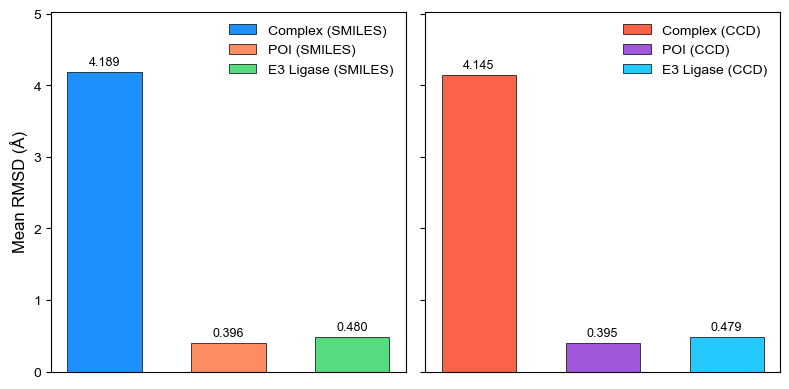

In [25]:
fig, axes = plot_mean_rmsd_vertical(df_complex_poi_e3_rmsd, 
                                   title=None,
                                   save=False,
                                   width=8,
                                   height=4,
                                   bar_width=0.6)

## HAL Paper Results Comparasion

---

In [26]:
# Copy of df_af3 with only the columns we want to compare
comparison_df = df_af3[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE']].copy()

# Merge SMILES data
hal_columns = ['PDB_ID', 'AF3_DIMERS DOCKQ SCORE']
comparison_df = comparison_df.merge(df_hal[hal_columns], on='PDB_ID', how='left')

# Remove rows with null values in any of the DockQ score columns
comparison_df = comparison_df.dropna(subset=['SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE'])

# Sort by release date (oldest to newest)
comparison_df = comparison_df.sort_values('PDB_RELEASE_DATE', ascending=True)


In [27]:
def plot_comparison_combined_horizontal(df,
                                        metrics=[
                                            ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE', 'DockQ Score')
                                        ],
                                        title=None,
                                        add_threshold=False,
                                        threshold_values=[0.0],
                                        x_labels_on_all=False,
                                        width=10,
                                        height=9,
                                        save=False):
    # Check that the dataframe has the required columns.
    required_columns = set()
    for m in metrics:
        if len(m) == 4:
            required_columns.update([m[0], m[1], m[2]])
        elif len(m) == 3:
            required_columns.update([m[0], m[1]])
        else:
            raise ValueError("Metric tuple must be of length 3 or 4.")
    if not required_columns.issubset(df.columns):
        raise ValueError("DataFrame does not contain all required columns: " + str(required_columns))

    # Sort by release date (ascending)
    df_sorted = df.sort_values('PDB_RELEASE_DATE', ascending=True).reset_index(drop=True)
    
    # Create PDB ID labels and add an asterisk for structures released after the cutoff date
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
        for pdb, date in zip(df_sorted['PDB_ID'], df_sorted['PDB_RELEASE_DATE'])
    ]
    
    # Number of metrics to plot (for comparison_df this should be 1)
    n_metrics = len(metrics)
    n_pdbs = len(df_sorted)
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_metrics, 1, figsize=(width, height), sharex=not x_labels_on_all)
    if n_metrics == 1:
        axes = [axes]
    
    # Store handles for legend and threshold
    legend_handles = []
    threshold_handle = None
    
    # Bar width and positions
    bar_width = 0.25  # Width of each bar
    
    # Plot each metric (for our case, typically only one tuple with 4 items)
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Check if we are plotting three series (tuple length 4) or just two (tuple length 3)
        if len(metric) == 4:
            smiles_col, ccd_col, tertiary_col, axis_label = metric
            
            # Set up x-axis positions for grouped bars
            x = np.arange(n_pdbs)
            
            # Plot the CCD scores
            bar_ccd = ax.bar(
                x - bar_width, df_sorted[ccd_col],
                width=bar_width, color=color_1, 
                edgecolor='black', linewidth=edge_width,
                label='Ligand CCD'
            )
            
            # Plot the SMILES scores
            bar_smiles = ax.bar(
                x, df_sorted[smiles_col],
                width=bar_width, color=color_2, 
                edgecolor='black', linewidth=edge_width,
                label='Ligand SMILES'
            )
            
            # Plot the AF3 Dimers scores
            bar_tertiary = ax.bar(
                x + bar_width, df_sorted[tertiary_col],
                width=bar_width, color=color_7, 
                edgecolor='black', linewidth=edge_width,
                label='No Ligand'
            )
            
        elif len(metric) == 3:
            smiles_col, ccd_col, axis_label = metric
            
            # Set up x-axis positions for grouped bars
            x = np.arange(n_pdbs)
            
            # Plot the CCD scores
            bar_ccd = ax.bar(
                x - bar_width/2, df_sorted[ccd_col],
                width=bar_width, color=color_1, 
                edgecolor='black', linewidth=edge_width,
                label='Ligand CCD'
            )
            
            # Plot the SMILES scores
            bar_smiles = ax.bar(
                x + bar_width/2, df_sorted[smiles_col],
                width=bar_width, color=color_2, 
                edgecolor='black', linewidth=edge_width,
                label='Ligand SMILES'
            )
        else:
            raise ValueError("Metric tuple must be of length 3 or 4.")
        
        # Add a horizontal threshold line if requested and threshold value is not None
        if add_threshold and i < len(threshold_values) and threshold_values[i] is not None:
            current_threshold = ax.axhline(
                y=threshold_values[i], color='black', linestyle='--', 
                alpha=grid_alpha, linewidth=line_width,
                label=None  # Label handled in the legend below
            )
            if threshold_handle is None:
                threshold_handle = current_threshold
        
        # Set the axis label for this subplot
        ax.set_ylabel(axis_label)
        
        # Set x-ticks
        ax.set_xticks(x)
        if x_labels_on_all or i == n_metrics - 1:
            ax.set_xticklabels(pdb_labels, rotation=x_axis_rotation)
        else:
            ax.set_xticklabels([])
        
        # Set x-axis label only on the last subplot
        if i == n_metrics - 1:
            ax.set_xlabel('PDB Identifier')
        
        # Set axis limits
        ax.set_ylim(0.0)
        ax.set_xlim(-0.5, n_pdbs - 0.5)
        
        # For the legend, store the bar handles from the first subplot only
        if i == 0:
            if len(metric) == 4:
                legend_handles = [bar_ccd, bar_smiles, bar_tertiary]
            else:
                legend_handles = [bar_ccd, bar_smiles]
    
    # Add legend to the first subplot
    if legend_handles:
        if add_threshold:
            if threshold_handle is None:
                threshold_handle = axes[0].axhline(
                    y=0, color='black', linestyle='--', 
                    alpha=grid_alpha, linewidth=line_width,
                    visible=False
                )
            legend_handles.append(Line2D([0], [0], color='black', linestyle='--', 
                                        alpha=grid_alpha, linewidth=line_width,
                                        label='Threshold'))
                    
        axes[0].legend(handles=legend_handles,
                      loc='upper right',
                      framealpha=0,  # Transparent background
                      edgecolor='none',  # No border
                      bbox_to_anchor=(0.87, 1))
    
    # Add an overall title if provided
    if title:
        fig.suptitle(title, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

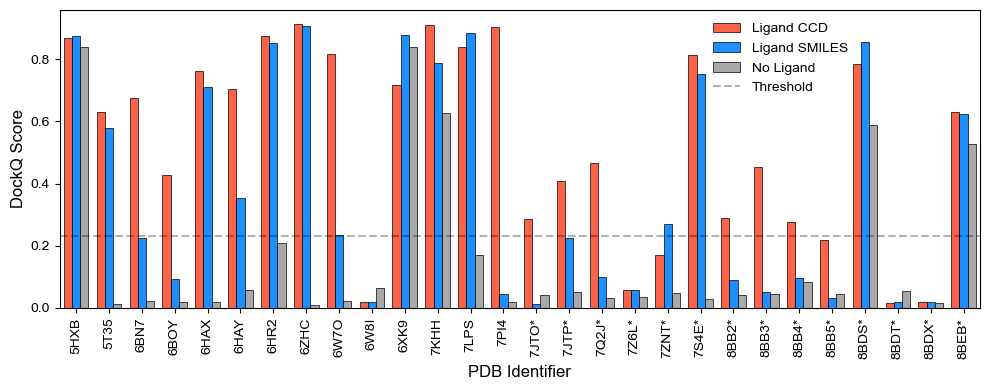

In [28]:
fig, axes = plot_comparison_combined_horizontal(
    comparison_df,
    metrics=[
        ('SMILES DOCKQ SCORE', 'CCD DOCKQ SCORE', 'AF3_DIMERS DOCKQ SCORE', 'DockQ Score')
    ],
    add_threshold=True,
    threshold_values=[0.23],
    x_labels_on_all=True,
    width=10,
    height=4,
    save=False
)

## Spearman Rank Correlations

---

In [29]:
def calculate_spearman_correlations(df):
    """
    Calculate Spearman rank correlations between specified pairs of variables.
    Returns both correlation coefficients and p-values.
    """
    # Define pairs to compare
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs ipTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs ipTM'),
        ('SMILES RMSD', 'SMILES PTM', 'SMILES RMSD vs PTM'),
        ('CCD RMSD', 'CCD PTM', 'CCD RMSD vs PTM'),
        ('SMILES RMSD', 'SMILES IPTM', 'SMILES RMSD vs ipTM'),
        ('CCD RMSD', 'CCD IPTM', 'CCD RMSD vs ipTM')
    ]
    
    results = []
    
    for var1, var2, label in pairs:
        # Remove rows with NaN values for this pair
        pair_df = df[[var1, var2]].dropna()
        
        # Calculate Spearman correlation
        correlation, p_value = stats.spearmanr(pair_df[var1], pair_df[var2])
        
        # Store results
        results.append({
            'Comparison': label,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': len(pair_df)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Format the results
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['P-value'] = results_df['P-value'].round(4)
    
    return results_df

In [30]:
correlation_results = calculate_spearman_correlations(df_af3)

# Display results in a nicely formatted table
print("\nSpearman Rank Correlations:")
print("============================")
print(correlation_results.to_string(index=False))


Spearman Rank Correlations:
          Comparison  Correlation  P-value  Sample Size
 SMILES DockQ vs PTM        0.584   0.0001           40
    CCD DockQ vs PTM        0.591   0.0001           40
SMILES DockQ vs ipTM        0.641   0.0000           40
   CCD DockQ vs ipTM        0.685   0.0000           40
  SMILES RMSD vs PTM       -0.519   0.0002           48
     CCD RMSD vs PTM       -0.502   0.0003           48
 SMILES RMSD vs ipTM       -0.574   0.0000           48
    CCD RMSD vs ipTM       -0.516   0.0002           48


In [31]:
def plot_correlation_pairs(df: pd.DataFrame, save: bool = False, title: str = None) -> None:
    COLORS = {'CCD': color_1, 'SMILES': color_2}
    comparisons = [
        {'title': 'DockQ Score vs pTM',
         'dockq_columns': ('CCD DOCKQ SCORE', 'SMILES DOCKQ SCORE'),
         'metric_columns': ('CCD PTM', 'SMILES PTM')},
        {'title': 'DockQ Score vs ipTM',
         'dockq_columns': ('CCD DOCKQ SCORE', 'SMILES DOCKQ SCORE'),
         'metric_columns': ('CCD IPTM', 'SMILES IPTM')},
    ]
    
    fig, axes = plt.subplots(1, len(comparisons), figsize=(10, 4))
    
    for i, (ax, comp) in enumerate(zip(axes, comparisons)):
        
        for source, dockq_col, metric_col in zip(COLORS.keys(), comp['dockq_columns'], comp['metric_columns']):
            subset = df[[dockq_col, metric_col]].dropna()
            corr, _ = stats.spearmanr(subset[dockq_col], subset[metric_col])
            marker = '^' if source == 'CCD' else 'o'
            label_text = f'Ligand {source} (ρ = {corr:.3f})'
            ax.scatter(subset[dockq_col], subset[metric_col],
                       color=COLORS[source],
                       edgecolor='black', linewidth=0.5,
                       s=60, marker=marker,
                       label=label_text)
        
        ax.set_xlabel('DockQ Score')
        ylabel = comp['title'].split(' vs ')[-1]
        if ylabel == 'RMSD':
            ylabel += ' (Å)'
        ax.set_ylabel(ylabel)
        ax.set_xlim(0)
        ax.set_ylim(0)
        legend_loc = 'lower right' if 'pTM' in comp['title'] or 'ipTM' in comp['title'] else 'best'
        ax.legend(fontsize=10, loc=legend_loc, edgecolor='none')
    
    plt.tight_layout()
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            
            plt.savefig(f'{save_path}/{filename}', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(filename, dpi=300)
    else:
        plt.show()

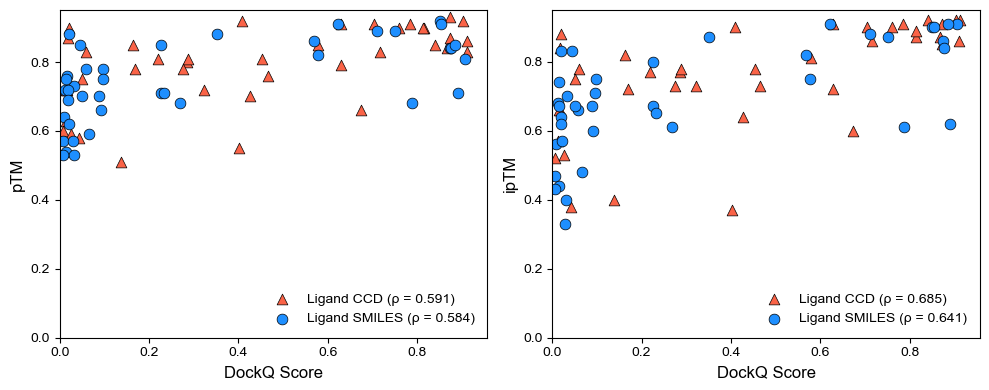

In [32]:
plot_correlation_pairs(df_af3, save=False)

In [33]:
def plot_correlation_pairs(df: pd.DataFrame, save: bool = False, title: str = None) -> None:
    COLORS = {'CCD': color_1, 'SMILES': color_2}
    comparisons = [
        {'title': 'RMSD vs pTM',
         'rmsd_columns': ('CCD RMSD', 'SMILES RMSD'),
         'metric_columns': ('CCD PTM', 'SMILES PTM')},
        {'title': 'RMSD vs ipTM',
         'rmsd_columns': ('CCD RMSD', 'SMILES RMSD'),
         'metric_columns': ('CCD IPTM', 'SMILES IPTM')},
    ]
    
    fig, axes = plt.subplots(1, len(comparisons), figsize=(10, 4))
    
    for i, (ax, comp) in enumerate(zip(axes, comparisons)):
        
        for source, rmsd_col, metric_col in zip(COLORS.keys(), comp['rmsd_columns'], comp['metric_columns']):
            subset = df[[rmsd_col, metric_col]].dropna()
            corr, _ = stats.spearmanr(subset[rmsd_col], subset[metric_col])
            marker = '^' if source == 'CCD' else 'o'
            label_text = f'Ligand {source} (ρ = {corr:.3f})'
            ax.scatter(subset[rmsd_col], subset[metric_col],
                       color=COLORS[source],
                       edgecolor='black', linewidth=0.5,
                       s=60, marker=marker,
                       label=label_text)
        
        ax.set_xlabel('RMSD (Å)')
        ylabel = comp['title'].split(' vs ')[-1]
        if ylabel == 'RMSD':
            ylabel += ' (Å)'
        ax.set_ylabel(ylabel)
        ax.set_xlim(0)
        ax.set_ylim(0)
        legend_loc = 'lower right' if 'pTM' in comp['title'] or 'ipTM' in comp['title'] else 'best'
        ax.legend(fontsize=10, loc=legend_loc, edgecolor='none')
    
    plt.tight_layout()
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            
            plt.savefig(f'{save_path}/{filename}', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(filename, dpi=300)
    else:
        plt.show()

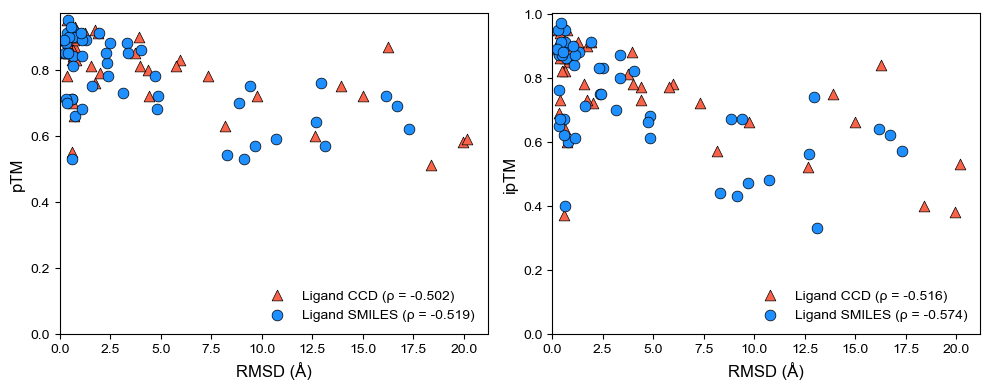

In [34]:
plot_correlation_pairs(df_af3, save=False)

In [35]:
bad_predictions_list = ['68WI', '7JTO', '7Z6L', '8BDT', '8BDX', '8FY1', '8QVU', '8QW6', '8QW7', '9B9T', '9DLW']

bad_predictions_df = df_af3[df_af3['PDB_ID'].isin(bad_predictions_list)]

In [36]:
bad_predictions_df.columns

Index(['PDB_ID', 'PDB_LINK', 'PDB_RELEASE_DATE', 'PBD_RESOLUTION (Å)',
       'PDB_R-VALUE FREE', 'PDB_R-VALUE WORK', 'PDB_R-VALUE OBSERVED',
       'SMILES RMSD', 'SMILES DOCKQ SCORE', 'SMILES DOCKQ iRMSD',
       'SMILES DOCKQ LRMSD', 'SMILES FRACTION DISORDERED', 'SMILES HAS_CLASH',
       'SMILES IPTM', 'SMILES PTM', 'SMILES RANKING_SCORE', 'CCD RMSD',
       'CCD DOCKQ SCORE', 'CCD DOCKQ iRMSD ', 'CCD DOCKQ LRMSD',
       'CCD FRACTION DISORDERED', 'CCD HAS_CLASH', 'CCD IPTM', 'CCD PTM',
       'CCD RANKING_SCORE'],
      dtype='object')

In [37]:
columns_to_drop = ['PDB_LINK', 'PDB_RELEASE_DATE', 'PBD_RESOLUTION (Å)',
       'PDB_R-VALUE FREE', 'PDB_R-VALUE WORK', 'PDB_R-VALUE OBSERVED','SMILES RMSD', 'SMILES DOCKQ SCORE', 'SMILES DOCKQ iRMSD',
       'SMILES DOCKQ LRMSD', 'SMILES FRACTION DISORDERED', 'SMILES HAS_CLASH',
       'SMILES RANKING_SCORE', 'CCD RMSD',
       'CCD DOCKQ SCORE', 'CCD DOCKQ iRMSD ', 'CCD DOCKQ LRMSD',
       'CCD FRACTION DISORDERED', 'CCD HAS_CLASH','CCD RANKING_SCORE']

bad_predictions_df_ptm_iptm = bad_predictions_df.drop(columns=columns_to_drop)


In [38]:
bad_predictions_df_ptm_iptm 

,PDB_ID,SMILES IPTM,SMILES PTM,CCD IPTM,CCD PTM
19,7JTO,0.68,0.72,0.77,0.80
22,7Z6L,0.66,0.78,0.78,0.83
30,8BDT,0.64,0.72,0.66,0.72
33,8BDX,0.62,0.69,0.84,0.87
36,8QVU,0.44,0.54,0.57,0.63
37,8QW6,0.56,0.64,0.52,0.60
38,8QW7,0.67,0.75,0.66,0.72
42,8FY1,0.48,0.59,0.75,0.75
45,9B9T,0.43,0.53,0.38,0.58
47,9DLW,0.33,0.57,0.53,0.59


In [39]:
bad_predictions_df_ptm_iptm_rmsd = bad_predictions_df_ptm_iptm.merge(df_complex_poi_e3_rmsd, on='PDB_ID', how='left')

In [40]:
columns_to_drop = ['PDB_LINK','SMILES RMSD', 'CCD RMSD']
bad_predictions_df_ptm_iptm_rmsd = bad_predictions_df_ptm_iptm_rmsd.drop(columns=columns_to_drop)

In [41]:
bad_predictions_df_ptm_iptm_rmsd

,PDB_ID,SMILES IPTM,SMILES PTM,CCD IPTM,CCD PTM,PDB_RELEASE_DATE,SMILES RMSD POI,SMILES RMSD E3 LIGASE,CCD RMSD POI,CCD RMSD E3 LIGASE
0,7JTO,0.68,0.72,0.77,0.80,2021-10-06,0.242,0.324,0.242,0.318
1,7Z6L,0.66,0.78,0.78,0.83,2022-09-07,0.211,0.232,0.218,0.271
2,8BDT,0.64,0.72,0.66,0.72,2023-02-15,0.336,0.401,0.348,0.393
3,8BDX,0.62,0.69,0.84,0.87,2023-02-15,0.340,0.388,0.331,0.345
4,8QVU,0.44,0.54,0.57,0.63,2023-12-06,0.549,0.426,0.594,0.491
5,8QW6,0.56,0.64,0.52,0.60,2023-12-06,1.053,0.443,0.972,0.418
6,8QW7,0.67,0.75,0.66,0.72,2023-12-06,0.589,0.481,0.615,0.498
7,8FY1,0.48,0.59,0.75,0.75,2024-04-10,0.297,0.285,0.298,0.309
8,9B9T,0.43,0.53,0.38,0.58,2024-11-06,0.222,0.610,0.185,0.537
9,9DLW,0.33,0.57,0.53,0.59,2024-11-06,0.227,0.620,0.232,0.648


In [42]:
def calculate_spearman_correlations(df):
    """
    Calculate Spearman rank correlations between specified pairs of variables.
    Returns both correlation coefficients and p-values.
    
    Calculates correlations between:
    - SMILES RMSD POI vs SMILES PTM and SMILES IPTM
    - SMILES RMSD E3 LIGASE vs SMILES PTM and SMILES IPTM
    - CCD RMSD POI vs CCD PTM and CCD IPTM
    - CCD RMSD E3 LIGASE vs CCD PTM and CCD IPTM
    """
    # Define pairs to compare
    pairs = [
        ('SMILES RMSD POI', 'SMILES PTM', 'SMILES RMSD POI vs PTM'),
        ('SMILES RMSD POI', 'SMILES IPTM', 'SMILES RMSD POI vs IPTM'),
        ('SMILES RMSD E3 LIGASE', 'SMILES PTM', 'SMILES RMSD E3 LIGASE vs PTM'),
        ('SMILES RMSD E3 LIGASE', 'SMILES IPTM', 'SMILES RMSD E3 LIGASE vs IPTM'),
        ('CCD RMSD POI', 'CCD PTM', 'CCD RMSD POI vs PTM'),
        ('CCD RMSD POI', 'CCD IPTM', 'CCD RMSD POI vs IPTM'),
        ('CCD RMSD E3 LIGASE', 'CCD PTM', 'CCD RMSD E3 LIGASE vs PTM'),
        ('CCD RMSD E3 LIGASE', 'CCD IPTM', 'CCD RMSD E3 LIGASE vs IPTM'),
    ]
    
    results = []
    
    for var1, var2, label in pairs:
        # Remove rows with NaN values for this pair
        pair_df = df[[var1, var2]].dropna()
        
        # Calculate Spearman correlation
        correlation, p_value = stats.spearmanr(pair_df[var1], pair_df[var2])
        
        # Store results
        results.append({
            'Comparison': label,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': len(pair_df)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Format the results
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['P-value'] = results_df['P-value'].round(4)
    
    return results_df


In [43]:
correlation_results = calculate_spearman_correlations(bad_predictions_df_ptm_iptm_rmsd)

# Display results in a nicely formatted table
print("\nSpearman Rank Correlations:")
print("============================")
print(correlation_results.to_string(index=False))


Spearman Rank Correlations:
                   Comparison  Correlation  P-value  Sample Size
       SMILES RMSD POI vs PTM        0.030   0.9336           10
      SMILES RMSD POI vs IPTM        0.139   0.7009           10
 SMILES RMSD E3 LIGASE vs PTM       -0.517   0.1262           10
SMILES RMSD E3 LIGASE vs IPTM       -0.539   0.1076           10
          CCD RMSD POI vs PTM       -0.006   0.9867           10
         CCD RMSD POI vs IPTM       -0.091   0.8022           10
    CCD RMSD E3 LIGASE vs PTM       -0.839   0.0024           10
   CCD RMSD E3 LIGASE vs IPTM       -0.790   0.0065           10


In [44]:
def plot_correlation_pairs(df: pd.DataFrame, save: bool = False, title: str = None, 
                          selection: str = None) -> None:
    """
    Plots correlation pairs between RMSD and confidence metrics (PTM/IPTM).
    
    Plots are organized as follows:
    - Top left: pTM vs RMSD POI and RMSD E3 (SMILES only)
    - Top right: ipTM vs RMSD POI and RMSD E3 (SMILES only)
    - Bottom left: pTM vs RMSD POI and RMSD E3 (CCD only)
    - Bottom right: ipTM vs RMSD POI and RMSD E3 (CCD only)
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing RMSD and confidence metrics
    save : bool, optional
        Whether to save the plot
    title : str, optional
        Title for the saved plot file
    selection : str, optional
        Which plots to display: 'all', 'top', 'bottom', 'left', 'right', or 'none'
        Default is 'all' (plot all four subplots)
    """
    # Define colors for each data type
    COLORS = {
        'POI_SMILES': color_4,    
        'E3_SMILES': color_6,    
        'POI_CCD': color_3, 
        'E3_CCD': color_5    
    }
    
    # Define the four plots
    comparisons = [
        # Top left: pTM vs RMSD POI and RMSD E3 (SMILES only)
        {'metric_column': 'PTM',
         'source': 'SMILES',
         'rmsd_columns': ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
         'data_types': ('POI_SMILES', 'E3_SMILES'),
         'xlabel': 'RMSD (Å)',
         'ylabel': 'pTM',
         'position': (0, 0)},
        
        # Top right: ipTM vs RMSD POI and RMSD E3 (SMILES only)
        {'metric_column': 'IPTM',
         'source': 'SMILES',
         'rmsd_columns': ('SMILES RMSD POI', 'SMILES RMSD E3 LIGASE'),
         'data_types': ('POI_SMILES', 'E3_SMILES'),
         'xlabel': 'RMSD (Å)',
         'ylabel': 'ipTM',
         'position': (0, 1)},
        
        # Bottom left: pTM vs RMSD POI and RMSD E3 (CCD only)
        {'metric_column': 'PTM',
         'source': 'CCD',
         'rmsd_columns': ('CCD RMSD POI', 'CCD RMSD E3 LIGASE'),
         'data_types': ('POI_CCD', 'E3_CCD'),
         'xlabel': 'RMSD (Å)',
         'ylabel': 'pTM',
         'position': (1, 0)},
        
        # Bottom right: ipTM vs RMSD POI and RMSD E3 (CCD only)
        {'metric_column': 'IPTM',
         'source': 'CCD',
         'rmsd_columns': ('CCD RMSD POI', 'CCD RMSD E3 LIGASE'),
         'data_types': ('POI_CCD', 'E3_CCD'),
         'xlabel': 'RMSD (Å)',
         'ylabel': 'ipTM',
         'position': (1, 1)},
    ]
    
    # Filter comparisons based on selection
    if selection and selection.lower() != 'all':
        filtered_comparisons = []
        for comp in comparisons:
            row, col = comp['position']
            
            if selection.lower() == 'top' and row == 0:
                filtered_comparisons.append(comp)
            elif selection.lower() == 'bottom' and row == 1:
                filtered_comparisons.append(comp)
            elif selection.lower() == 'left' and col == 0:
                filtered_comparisons.append(comp)
            elif selection.lower() == 'right' and col == 1:
                filtered_comparisons.append(comp)
                
        comparisons = filtered_comparisons
    
    # Determine grid size based on selection
    if not comparisons or selection and selection.lower() == 'none':
        print("No plots selected.")
        return
        
    # Determine number of rows and columns for the grid
    positions = [comp['position'] for comp in comparisons]
    rows = [pos[0] for pos in positions]
    cols = [pos[1] for pos in positions]
    n_rows = max(rows) + 1 if rows else 1
    n_cols = max(cols) + 1 if cols else 1
    
    # Create figure with appropriate number of subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
    
    # Handle case of single subplot
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot each comparison
    for comp in comparisons:
        row, col = comp['position']
        ax = axes[row, col]
        metric_column = comp['metric_column']
        source = comp['source']
        full_metric_col = f"{source} {metric_column}"
        
        for rmsd_col, data_type in zip(comp['rmsd_columns'], comp['data_types']):
            subset = df[[rmsd_col, full_metric_col]].dropna()
            
            if len(subset) > 0:  # Check if there's data to plot
                corr, _ = stats.spearmanr(subset[rmsd_col], subset[full_metric_col])
                
                # Determine if this is POI or E3 data
                target_type = "POI" if "POI" in rmsd_col else "E3"
                marker = 'o' if target_type == "POI" else '^'
                label_text = f'{target_type} (ρ = {corr:.3f})'
                
                ax.scatter(subset[rmsd_col], subset[full_metric_col],
                          color=COLORS[data_type],
                          edgecolor='black', linewidth=0.5,
                          s=60, marker=marker,
                          label=label_text)
        
        ax.set_xlabel(comp['xlabel'])
        ax.set_ylabel(comp['ylabel'])
        ax.set_xlim(0)
        ax.set_ylim(0, 1)
        ax.legend(fontsize=10, loc='lower right', edgecolor='none')
    
    plt.tight_layout()
    if save:
        try:
            # Create directory if it doesn't exist
            import os
            save_path = '../data/plots'
            os.makedirs(save_path, exist_ok=True)
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"plot_{timestamp}"
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            
            plt.savefig(f'{save_path}/{filename}', dpi=300, bbox_inches='tight')
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(filename, dpi=300)
    else:
        plt.show()

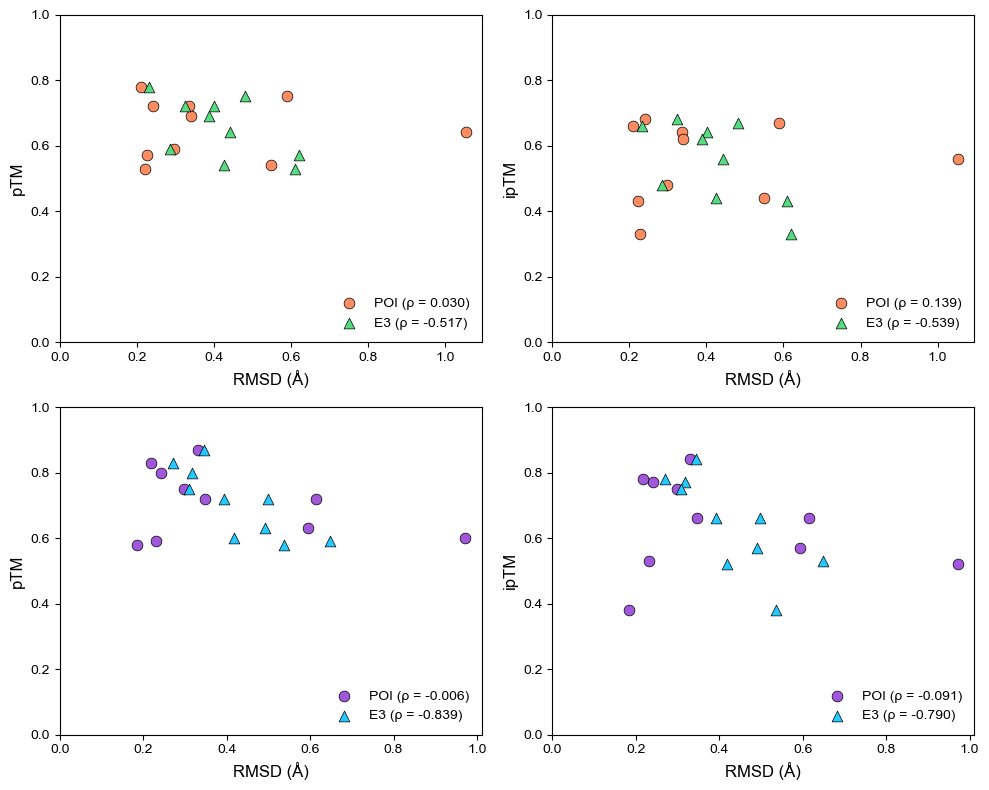

In [45]:
plot_correlation_pairs(bad_predictions_df_ptm_iptm_rmsd, save=False)

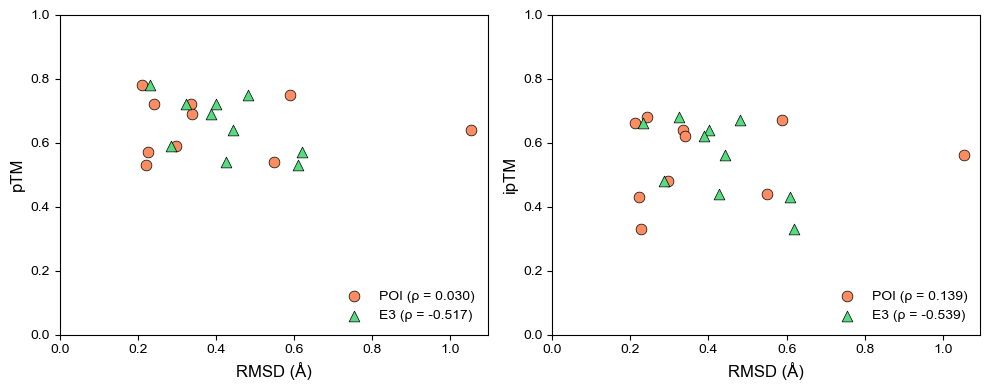

In [46]:
plot_correlation_pairs(bad_predictions_df_ptm_iptm_rmsd, save=False, selection='top')

# Ligands

In [47]:
# Load molecular descriptors and order by PDB_ID to match df_af3
df_mol_descriptors = pd.read_csv('../data/molecular_descriptors.csv')
# Ensure PDB_ID order matches df_af3
df_mol_descriptors = df_mol_descriptors.set_index('PDB_ID').reindex(df_af3['PDB_ID']).reset_index()


In [48]:
df_mol_descriptors_with_date = df_mol_descriptors.merge(df_af3[['PDB_ID', 'PDB_RELEASE_DATE']], on='PDB_ID', how='left')

In [49]:
def plot_molecular_properties(df, 
                             property_sets=[
                                 ('Molecular_Weight', 'Molecular Weight (Da)'),
                                 ('LogP', 'LogP'),
                                 ('TPSA', 'TPSA (Å²)')
                             ],
                             title=None,
                             width=12,
                             height=8,
                             bar_height=0.6,
                             color_scheme=None,
                             show_values=True,
                             decimal_places=1,
                             value_fontsize=8,
                             show_all_yticks=0,
                             save=False,
                             save_path='../data/plots'):
    
    # Sort by PDB_ID
    df_sorted = df.sort_values('PDB_ID', ascending=False).reset_index(drop=True)
    
    # Create PDB ID labels with ligand ID
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [
        f"{pdb}* ({ligand})" if 'PDB_RELEASE_DATE' in df_sorted.columns and pd.to_datetime(date) > cutoff_date else f"{pdb} ({ligand})" 
        for pdb, ligand, date in zip(df_sorted['PDB_ID'], df_sorted['ligand_ID'], 
                                    df_sorted['PDB_RELEASE_DATE'] if 'PDB_RELEASE_DATE' in df_sorted.columns 
                                    else [None] * len(df_sorted))
    ]
        
    # Number of properties to plot
    n_properties = len(property_sets)
    n_compounds = len(df_sorted)
    
    # Default colors if not provided
    if color_scheme is None:
        color_scheme = [color_1, color_2, color_3]  # blue, red, green
    
    # Ensure we have enough colors
    while len(color_scheme) < n_properties:
        color_scheme.append(color_3)  # Add gray for any additional properties
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_properties, figsize=(width, height), sharey=(show_all_yticks == 0))
    
    # If only one property, axes won't be an array
    if n_properties == 1:
        axes = [axes]
    
    # Set up y-axis positions (one position per compound)
    y = np.arange(n_compounds)
    
    # Format string for value labels based on decimal places
    if decimal_places == 0:
        format_str = '{:.0f}'
    else:
        format_str = '{:.' + str(decimal_places) + 'f}'
    
    # Plot each property
    for i, (property_col, axis_label) in enumerate(property_sets):
        ax = axes[i]
        
        # Plot the bars
        bars = ax.barh(
            y, df_sorted[property_col], height=bar_height,
            color=color_scheme[i], edgecolor='black', linewidth=0.5
        )
        
        # Add value labels at the end of each bar if requested
        if show_values:
            for bar_idx, bar in enumerate(bars):
                width = bar.get_width()
                ax.text(width + (max(df_sorted[property_col]) * 0.01), 
                       bar.get_y() + bar.get_height()/2, 
                       format_str.format(width), 
                       va='center', fontsize=value_fontsize)
        
        # Set axis labels
        ax.set_xlabel(axis_label, fontsize=axis_label_size)
        
        # Set y-ticks and labels based on show_all_yticks parameter
        ax.set_yticks(y)
        
        if i == 0 or show_all_yticks:
            ax.set_yticklabels(pdb_labels)
        else:
            ax.set_yticklabels([])
        
        # Only set the y-axis label for the first subplot
        if i == 0:
            ax.set_ylabel('PDB Identifier (Ligand Identifier)', fontsize=axis_label_size)
        
        # Set x-axis to start at 0
        ax.set_xlim(0, max(df_sorted[property_col]) * 1.1)  # Add 10% padding
        ax.set_ylim(-0.5, len(df_sorted) - 0.5)
    
    # Add overall title if provided
    if title:
        fig.suptitle(title, fontsize=14, y=0.98)
    
    plt.tight_layout()
    
    # Save the plot if required
    if save:
        try:
            # Create directory if it doesn't exist
            os.makedirs(save_path, exist_ok=True)
            
            # Create a filename based on the title or timestamp if no title
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = title.lower().replace(' ', '_') if title else f"molecular_properties_{timestamp}"
            # Remove any special characters that might cause issues in filenames
            filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
            plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
            print(f"Figure saved to {save_path}/{filename}.png")
        except Exception as e:
            print(f"Error saving figure: {e}")
            # Save to current directory as fallback
            plt.savefig(f"{filename}.png", dpi=300, bbox_inches='tight')
    
    return fig, axes

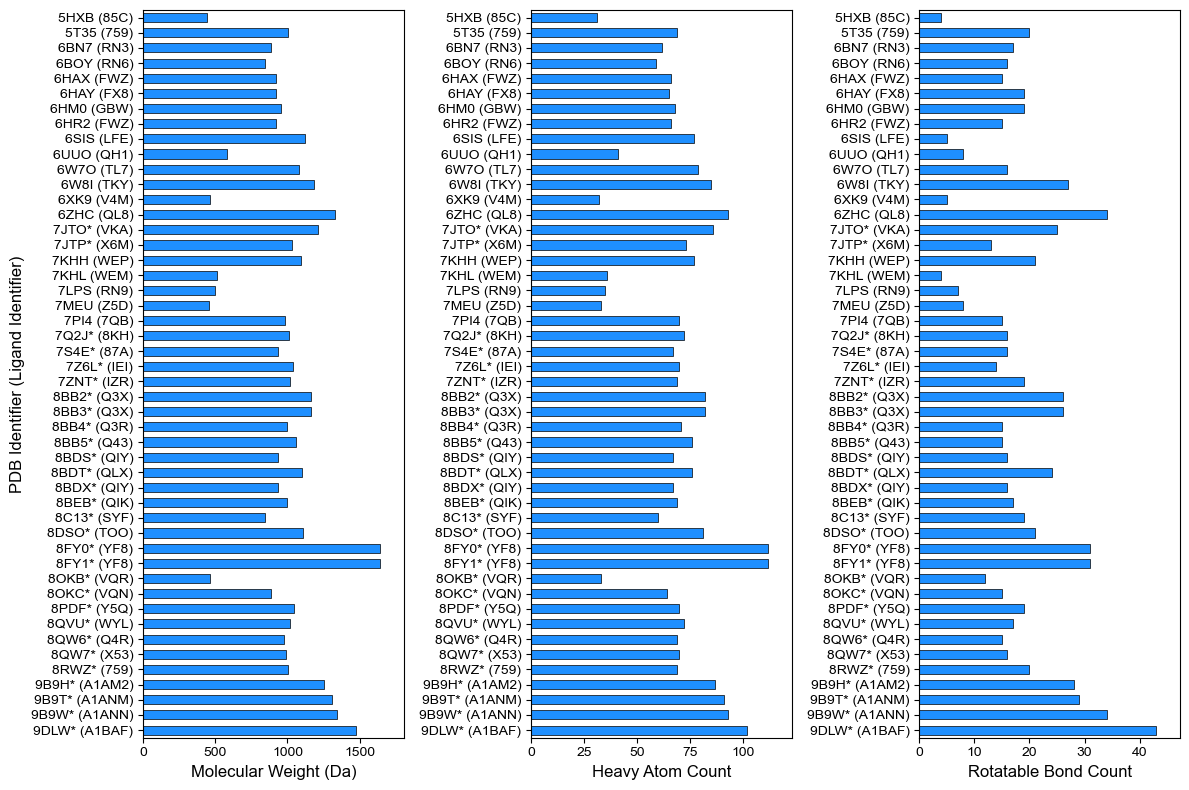

In [50]:
fig, axes = plot_molecular_properties(
    df_mol_descriptors_with_date, 
    property_sets=[
        ('Molecular_Weight', 'Molecular Weight (Da)'),
        ('Heavy_Atom_Count', 'Heavy Atom Count'),
        ('Rotatable_Bond_Count', 'Rotatable Bond Count')
    ],
    decimal_places=0,  
    value_fontsize=10,
    show_values=False,
    color_scheme=[color_2, color_2, color_2],
    save=False,
    show_all_yticks=1
)

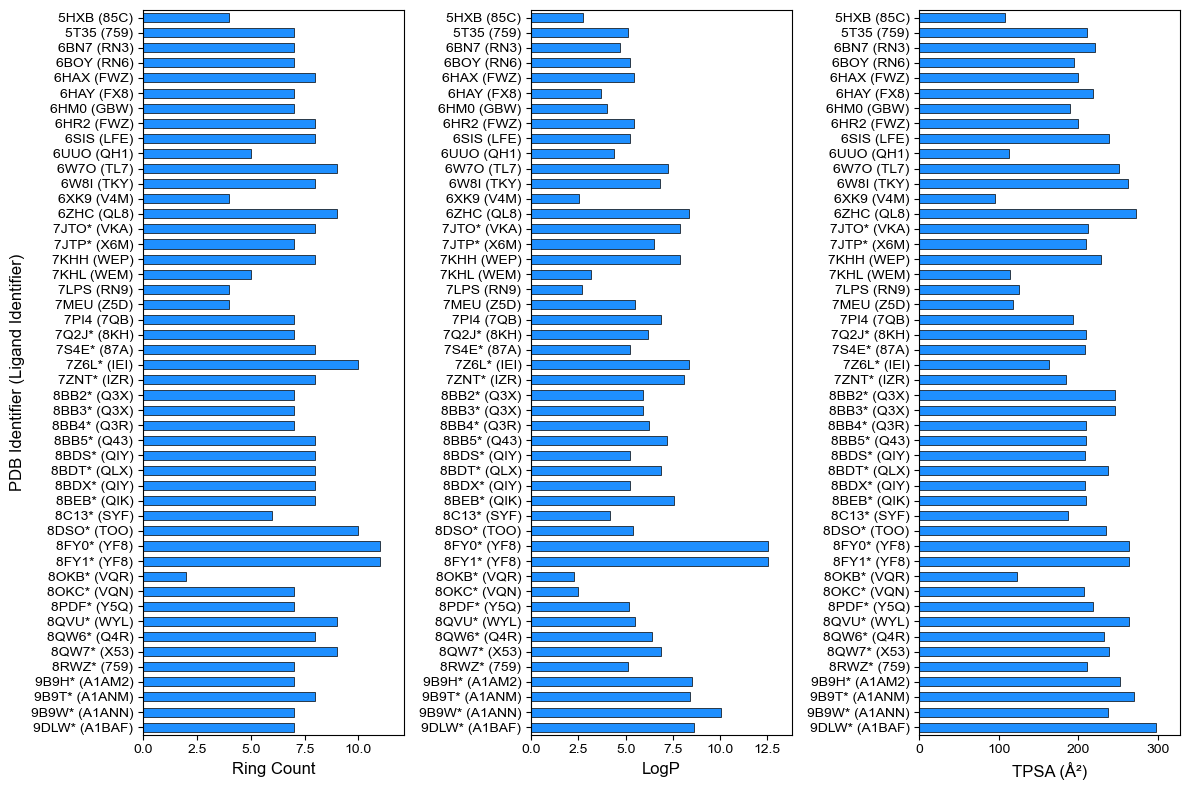

In [51]:
fig, axes = plot_molecular_properties(
    df_mol_descriptors_with_date, 
    property_sets=[
        ('Ring_Count', 'Ring Count'),
        ('LogP', 'LogP'),
        ('TPSA', 'TPSA (Å²)')
    ],
    decimal_places=0,  
    value_fontsize=10,
    show_values=False,
    color_scheme=[color_2, color_2, color_2],
    save=False,
    show_all_yticks=1
)

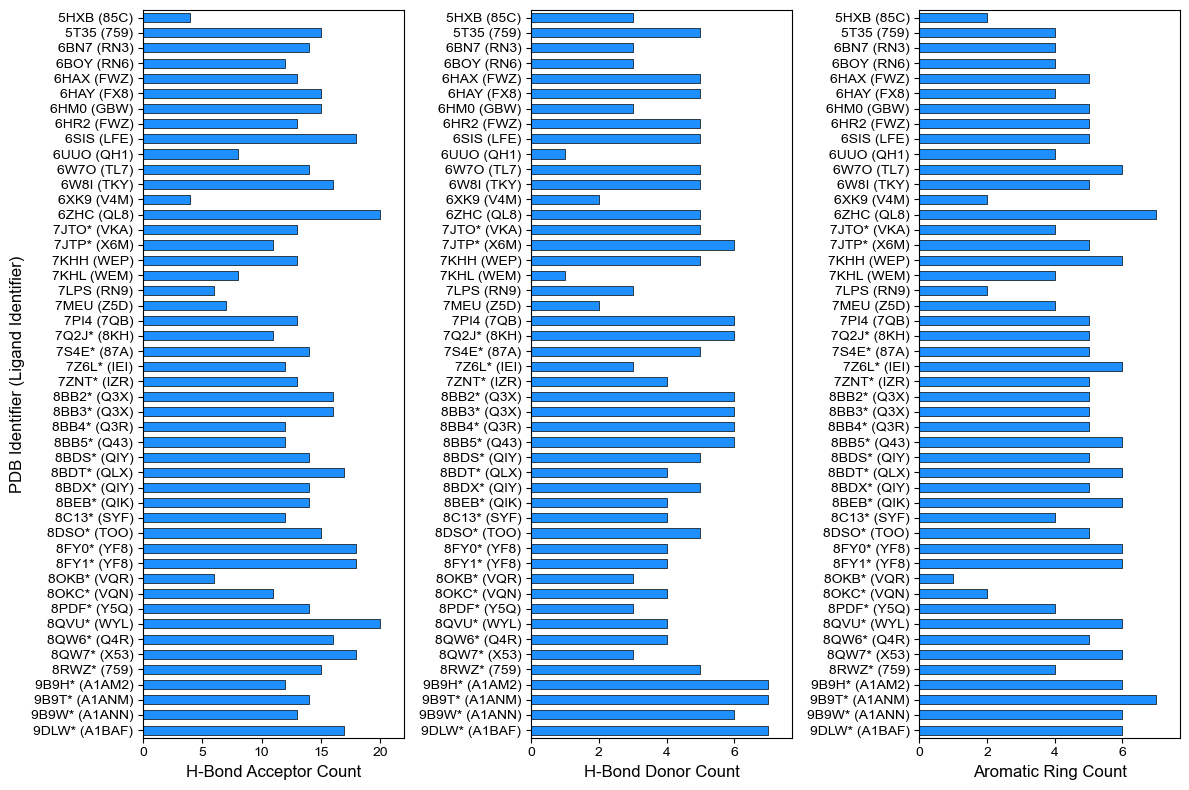

In [52]:
fig, axes = plot_molecular_properties(
    df_mol_descriptors_with_date, 
    property_sets=[
        ('HBA_Count', 'H-Bond Acceptor Count'),
        ('HBD_Count', 'H-Bond Donor Count'),
        ('Aromatic_Rings', 'Aromatic Ring Count')
    ],
    decimal_places=0,  
    value_fontsize=10,
    show_values=False,
    color_scheme=[color_2, color_2, color_2],
    save=False,
    show_all_yticks=1
)